# Mapping barcodes and promoters

© 2022 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [3]:
using wgregseq, CSV, DataFrames, Glob, BioSequences, CairoMakie, Statistics

# Set plotting style
wgregseq.plotting_style.default_makie!()

In this notebook we analyze the processed sequencing data in order to map the promoter variants to barcode sequences. Previously, the sequencing reads were filtered and we extracted barcode and promoter sequences from the reads. Now, we have to identify which promoter each sequence belongs to. In the experiment we had four different subpools, each subpool containing a different number of oligos.
The subpools are named by the primer number we used for initial amplification (110, 201, 204, 100):
- 110: 5
- 201: 20
- 204: 13
- 100: 119

## Import twist order

First we import the twist order to identify which promoter a sequence belongs to.

In [4]:
# Import table with custom function for correct column types
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")

# Take promoter sequence from oligo
promoter_seqs = [seq[27:196] for seq in df_seqs.sequence]

# Add promoter sequence to table
insertcols!(df_seqs, 4, :promoter_seq => [x[27:186] for x in df_seqs.sequence])

first(df_seqs, 5)

,genes,sequence
,Array…,LongSequ…
1,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
2,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGTCTTTTTTTGTGATCACTCCGGCTATATTCGATCTATTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCGTCACGACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
3,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGCCTGTTTGTGTGATCACTACGGCGTTTTTCAATCTTTATACTTGTATGGTAGTCTCTCAGTTGCGTAGATTTGCTGCATCACGACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
4,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTGTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGCCTTTTCTCGAGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTGAGTTGTGTAGTTTTCATGCATCACAACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC
5,"[""rspA"", ""rspB""]",ACCTGTAATTCCAAGCGTCTACTAGTTTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGCCTTCTTTTGTGATCACTCAGGCTCTTTTCGATCTTTCTACTAGTATGGTAATAGCTAATTTGCGTGGATTGCATGCATCACGACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGGGGGCCCGGGCACAGCAATCAAAAGTCGTGTAAAATCCGAGAACCGAATACGTGCCTGAGACAAC


Write primers and promoter sequences to dictionary for easier mapping. This only allows for exact mapping, meaning we do not identify any sequences that have mutations.

In [5]:
# Store twist sequences in dictionary
dict_twist_sequences = Dict(df_seqs.promoter_seq .=> df_seqs.promoter);
dict_twist_primer2 = Dict(df_seqs.promoter_seq .=> df_seqs.rev_primer2);
dict_twist_primer3 = Dict(df_seqs.promoter_seq .=> df_seqs.rev_primer3);

## Import Data for 110

First we look at the smallest subpool. We import the table with barcode and promoter sequences, as well as their read counts.

In [6]:
# Import data file
df_110 = CSV.read(
    "../../../data/barcodes/20220514_mapping/110_collapsed.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_110.barcode = map(x -> LongDNA{4}(x), df_110.barcode)
df_110.promoter = map(x -> LongDNA{4}(x), df_110.promoter)

# Display first lines
first(df_110, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,12585,TTATTAGGATCCCTCACCAA,CGGGGATGTTTTGGCGCGTTACTTGCGCTTCTAGTTTGGTTTTTCGTGCCGTATGTTCGTGCGGTTACAGGCGTTAGATTCACCTACTTTTGTGAATGTATGTAGCATAGCTCAACGACAATATAAACGCAGTAATGGGTTTATTAACTTTTGACCATTG
2,11223,GTCCCGATGGGCACCGATAA,TTTGACTGCCGATTGAGAAGTCATGTGTTAAATGGCGGCACATACATGCACTATGGCACATAACGCCAACCTCTTGCCGTAGCGGCTTCTGCTAGTATCCGCAATAATTTTACATTGTAATCGCGCTAAATACTGCTTCACCACAAGGAATTCAAATGAA
3,8181,GGCGGACTCTTTGACTTTCG,GCCTGCATGTCAAAGTCCTGGTAAAAGTCTTATTGTGACGGAAAACGAACGCCACGCAAAGCTAACCGGACAATAGTGTAGTGCTTTTCTGTGCTTAGCGGTTAGAATATTCTCATCACTATATCTGGCGTTGTCCATGTTATAGTTATTAAAAAGTTTA
4,7576,CAATGCTGTCGAACACATTC,CAGCCCATAGAGGAACTGCAACTATTGCAAATGAAGAAATTAAGCTGGATGGCATCGCGCAATGAGGAAGATTGGCCGGGGCTGACAGTAAATAGCAATCGTAGAATCAGCCGCAAGCCCGAAAGATTCCAGTGAGGCGCAATGTTCCGGGGGCTTTAGC
5,6880,ATTCGGTATTTAATATCGCC,TGGATCTGACTGGAGTGAGATAGGCATCATCTAACGCATCGTCGCTAATACCATACTAAAACGATTGTAACGACGTGCTGCTTTCATAACCTGCACGTACTGTATGATTATCCAGTTAGCTCTGAGGCGTTTTCACGCTGGCAAGGCGCATAAACTCTTT


Filter by having at minimum 3 counts per barcode - promoter combination.

In [7]:
df_filt_110 = df_110[df_110.counts .> 2, :]
last(df_filt_110, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAAGTTTTGCTTTGTT,GCACTATGAATGGGCAGTGAGTGCGTTTTTTTGTCCCAAGTCGTCGTCTTTACTGAGCAAAAAAAATAATATCTCCTATACGAGAATCAACACTTGGGGTGAATAAGTTTTGCGTCGCCAGAGCGTTTTATATTGATAGGAGTCAAATTATGGAAGGTAA
2,3,AAAAAAAGTGTATATCTTTT,CTGGCTTAAGCATTGTTATTGACCTGGCACTAATAGTGAATTAAATGTGAACTTCAGCGTCGTTTGACTGCCGTTTGAGCAGTCATGCGTTATATTGAGGCTCATTACCCCCCAATGACACGTAACGCCAACCTTTTTCCGTAGCCGCTCTTGCTATAAC
3,3,AAAAAAAGACCTTTGTAGGA,TGGCTCTGGCTGGAGTGAGATACCCATCGTCTATGGCAGAAATGCTAACACCATACTGAAATTATTGCAAGGACGTGCTGGTATTATAACCTGCATGTACTGTATCATTATCCAGTTAGCTCTAAGCCATTTCCTCTCTGGCAATGCGCAGAAACGCTTT
4,3,AAAAAAACTAGGCCGGTTTT,GCACAAAGAATGCGCAGAGAGCGCTTTTTTTTGTCCCCAGTCATCCCCTTTACTGAGCAAAGCAAAGAATGTCTCCTACATGAGTAGGATCAATCGGAGATAATAAGTTTTGCTTCCCCAGAGCGTTTAATATTGATAGGAGGCTTATTCTGGAAGGTAA
5,3,AAAAAAAATGACAAATGAAG,CGAAGATGTGTTGGCGGGTTTCTGGCGCTTCTTGTTTGGTTTATCGTGCCATATGTGCGTGAATTTACAGTCGTTAGAGTGACATACATTGGTGAATGTAAGTACCATAGCACGACGATAATATAAACGAAGCAATGGGTTTGTTAAAATTTGACCATAT


Find promoters for sequences. So far we only do perfect matching.

In [8]:
# Arrays to store names and primers
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

# Iterate through dataframe
for i in 1:nrow(df_filt_110)
    if df_filt_110.promoter[i] in keys(dict_twist_sequences)
        push!(name_list, dict_twist_sequences[df_filt_110.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_110.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_110.promoter[i]])
    else
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_110, 1, :name => name_list);
insertcols!(df_filt_110, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_110, 3, :rev_primer3 => primer3_list);

### Count total counts per gene.

Let's have a look at the total number of counts per promoter. That means that we sum up the counts for all variants for a promoter. We will color the genes in our subpool blue, and other genes orange.

┌ Warning: Could not find font /Users/tomroeschinger/.julia/packages/Makie/lgPZh/assets/fonts/NotoSans-Regular.tff, using Dejavu Sans
└ @ Makie /Users/tomroeschinger/.julia/packages/Makie/lgPZh/src/conversions.jl:946


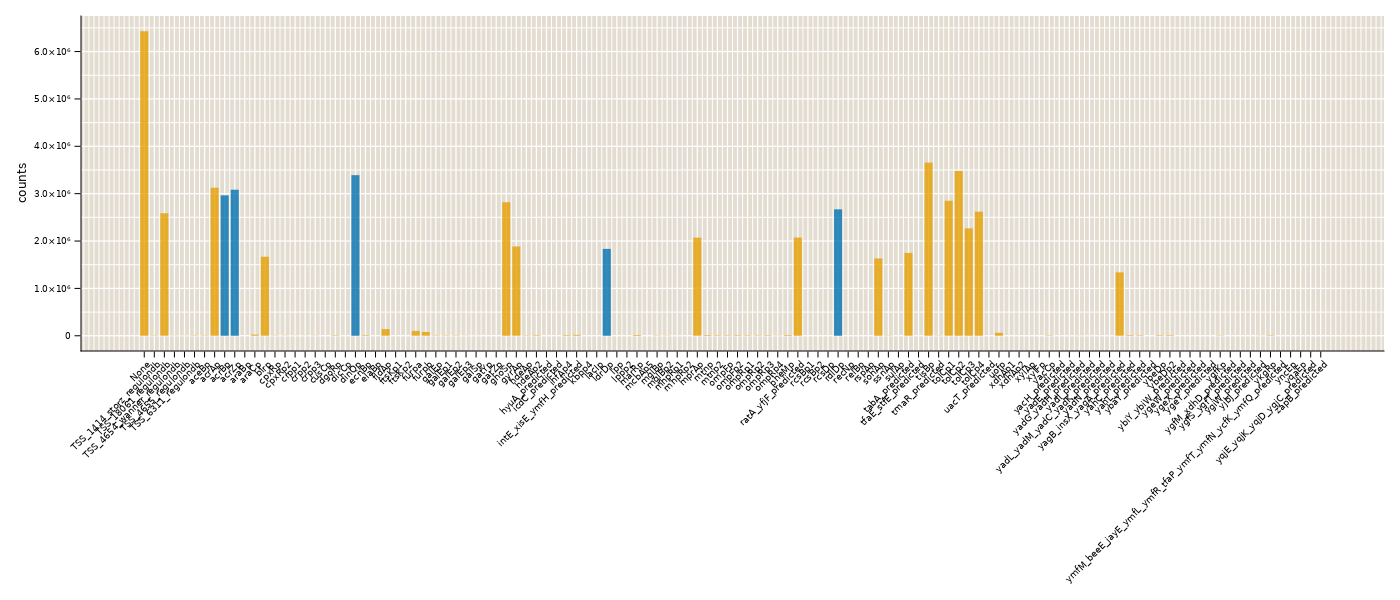

In [9]:
df_per_promoter_110 = combine(groupby(df_filt_110, [:name, :rev_primer2]), :counts => sum => :counts)
sort!(df_per_promoter_110, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])

barplot!(
    ax, 
    1:nrow(df_per_promoter_110), 
    df_per_promoter_110.counts .* map(x -> x[1] == 110, df_per_promoter_110.rev_primer2)
)

barplot!(
    ax, 
    1:nrow(df_per_promoter_110), 
    df_per_promoter_110.counts .* map(x -> x[1] != 110, df_per_promoter_110.rev_primer2)
)

ax.xticks = (1:nrow(df_per_promoter_110), df_per_promoter_110.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

Here we can see that there are counts belonging to genes in a different subpool. After looking into this, we found that this pool must have been mixed with the subpool 201. Below is the same plot, but now we mark all genes blue that belong to subpool 201.

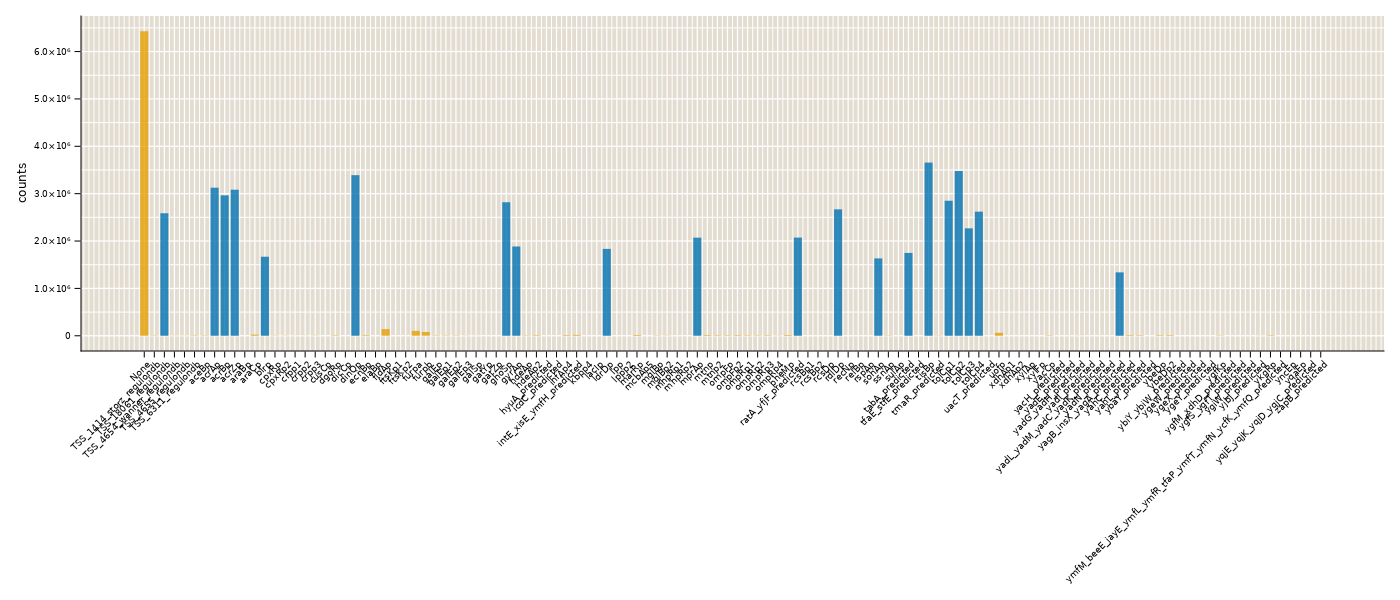

In [10]:
df_per_promoter_110 = combine(groupby(df_filt_110, [:name, :rev_primer3]), :counts => sum => :counts)
sort!(df_per_promoter_110, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])

barplot!(
    ax, 
    1:nrow(df_per_promoter_110), 
    df_per_promoter_110.counts .* map(x -> x[1] == 201, df_per_promoter_110.rev_primer3)
)

barplot!(
    ax, 
    1:nrow(df_per_promoter_110), 
    df_per_promoter_110.counts .* map(x -> x[1] != 201, df_per_promoter_110.rev_primer3)
)

ax.xticks = (1:nrow(df_per_promoter_110), df_per_promoter_110.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

So we see that most identified reads belong actually to subpool 201. There must have been a mix up during the cloning process, or some kind of contamination between the two.

### Mean number of barcodes per variant

Now we compute the mean number of unique barcodes per promoter variant.

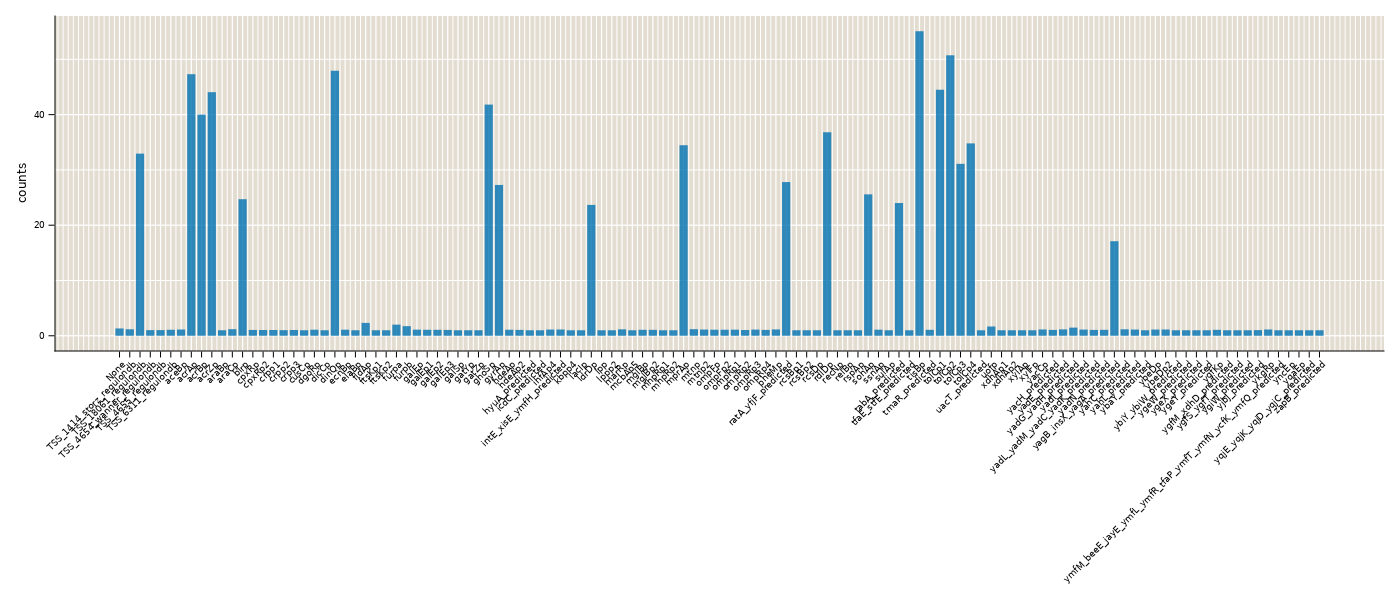

In [11]:
# Compute mean number of barcodes
df_mean_barcodes_110 = combine(
    groupby(
        combine(
            groupby(
                df_filt_110, 
                [:promoter, :name]
                ), 
            nrow
            ), 
        :name
        ), 
        :nrow => mean => :mean_barcodes
        )

# Sort by name
sort!(df_mean_barcodes_110, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_mean_barcodes_110), 
    df_mean_barcodes_110.mean_barcodes,
)

ax.xticks = (1:nrow(df_mean_barcodes_110), df_mean_barcodes_110.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

### Number of variants with at least 10 barcodes.

Next we look for the fraction of variants that have at least barcodes. This threshold is slightly arbitrary, but ensures that we have enough statistics. 

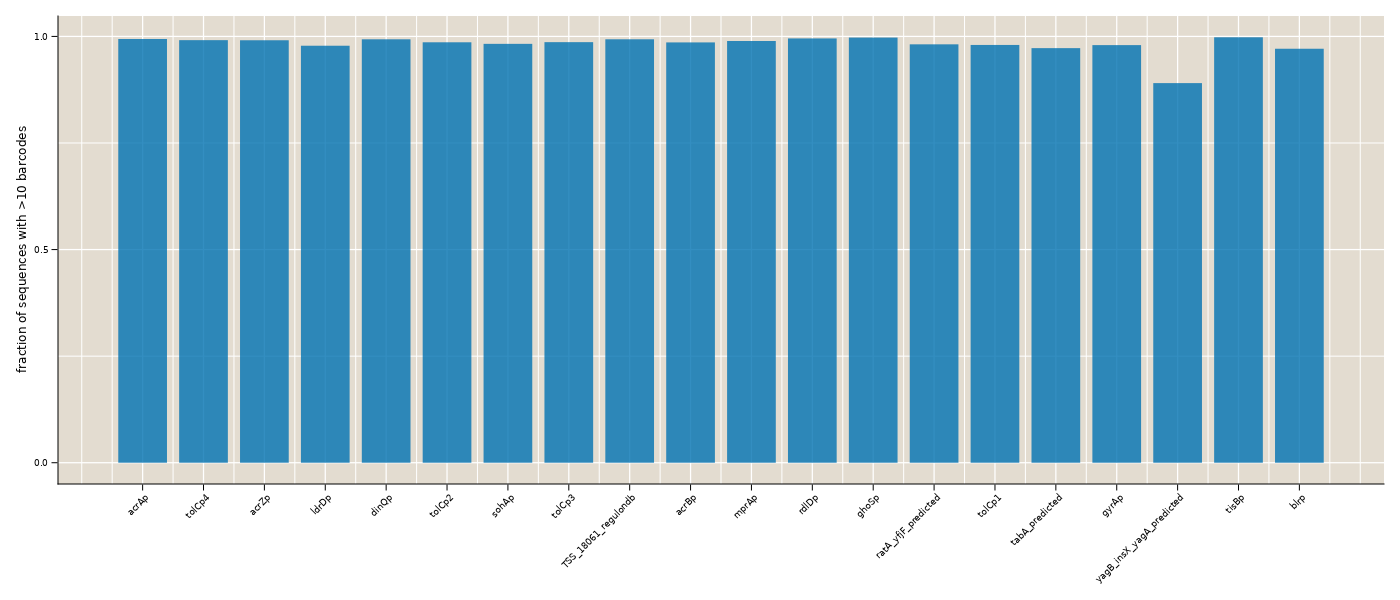

In [12]:
df_filt_110 = df_filt_110[map(x -> x[1] == 201, df_filt_110.rev_primer3), :]

df_barcodes_thresh_110 = combine(
    groupby(
        df_filt_110, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)

insertcols!(df_barcodes_thresh_110, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_110.nrow))
df_barcodes_thresh_110 = combine(
    groupby(
        df_barcodes_thresh_110, 
        [:name, :rev_primer3, :rev_primer2]
    ), 
    :thresh => mean => :fraction_passed
)      

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_barcodes_thresh_110), 
    df_barcodes_thresh_110.fraction_passed,
)

ax.xticks = (1:nrow(df_barcodes_thresh_110), df_barcodes_thresh_110.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "fraction of sequences with >10 barcodes"

fig

Finally we map count the total number of unique promoter variants that have at least 10 unique barcodes each.

In [13]:
num_unique(x) = length(unique(x))

num_unique (generic function with 1 method)

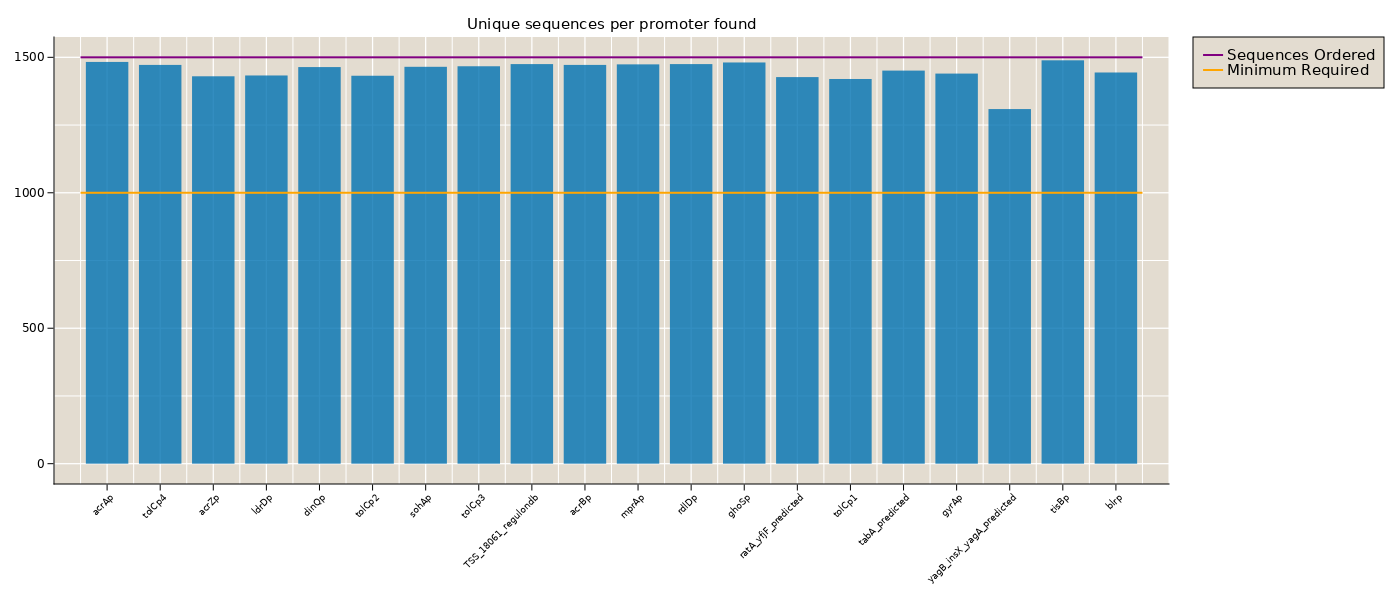

In [14]:
df_barcodes_thresh_110 = combine(
    groupby(
        df_filt_110, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)

df_barcodes_thresh_110 = df_barcodes_thresh_110[df_barcodes_thresh_110.name .!= "None", :]

insertcols!(df_barcodes_thresh_110, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_110.nrow))
df_barcodes_thresh_110 = df_barcodes_thresh_110[df_barcodes_thresh_110.thresh .== 1, :]

df_unique_per_prom_110 = combine(groupby(df_barcodes_thresh_110, :name), :promoter => num_unique);
df_unique_per_prom_110 = df_unique_per_prom_110[df_unique_per_prom_110.name .!= "None", :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_110), 
    df_unique_per_prom_110.promoter_num_unique,
)

ax.xticks = (1:nrow(df_unique_per_prom_110), df_unique_per_prom_110.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
#ax.ylabel = "Unique sequences per promoter"
ax.title = "Unique sequences per promoter found"
ax.titlesize=15
xlims!(0, nrow(df_unique_per_prom_110)+1)

maxi = lines!(ax, [0.5, nrow(df_unique_per_prom_110)+0.5], [1500, 1500], color="purple", linewidth=2)
mini = lines!(ax, [0.5, nrow(df_unique_per_prom_110)+0.5], [1000, 1000], color="orange", linewidth=2)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)

fig

## Import Data for 201

Next we look at the 201 subpool. We will look at the same statistics as before.

In [15]:
# Import data file
df_201 = CSV.read(
    "../../../data/barcodes/20220514_mapping/201_collapsed.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_201.barcode = map(x -> LongDNA{4}(x), df_201.barcode)
df_201.promoter = map(x -> LongDNA{4}(x), df_201.promoter)

# Display first lines
first(df_201, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,13287,TTATTAGGATCCCTCACCAA,CGGGGATGTTTTGGCGCGTTACTTGCGCTTCTAGTTTGGTTTTTCGTGCCGTATGTTCGTGCGGTTACAGGCGTTAGATTCACCTACTTTTGTGAATGTATGTAGCATAGCTCAACGACAATATAAACGCAGTAATGGGTTTATTAACTTTTGACCATTG
2,11802,GTCCCGATGGGCACCGATAA,TTTGACTGCCGATTGAGAAGTCATGTGTTAAATGGCGGCACATACATGCACTATGGCACATAACGCCAACCTCTTGCCGTAGCGGCTTCTGCTAGTATCCGCAATAATTTTACATTGTAATCGCGCTAAATACTGCTTCACCACAAGGAATTCAAATGAA
3,8333,GGCGGACTCTTTGACTTTCG,GCCTGCATGTCAAAGTCCTGGTAAAAGTCTTATTGTGACGGAAAACGAACGCCACGCAAAGCTAACCGGACAATAGTGTAGTGCTTTTCTGTGCTTAGCGGTTAGAATATTCTCATCACTATATCTGGCGTTGTCCATGTTATAGTTATTAAAAAGTTTA
4,7848,CAATGCTGTCGAACACATTC,CAGCCCATAGAGGAACTGCAACTATTGCAAATGAAGAAATTAAGCTGGATGGCATCGCGCAATGAGGAAGATTGGCCGGGGCTGACAGTAAATAGCAATCGTAGAATCAGCCGCAAGCCCGAAAGATTCCAGTGAGGCGCAATGTTCCGGGGGCTTTAGC
5,7379,ATTCGGTATTTAATATCGCC,TGGATCTGACTGGAGTGAGATAGGCATCATCTAACGCATCGTCGCTAATACCATACTAAAACGATTGTAACGACGTGCTGCTTTCATAACCTGCACGTACTGTATGATTATCCAGTTAGCTCTGAGGCGTTTTCACGCTGGCAAGGCGCATAAACTCTTT


## Filtering

Now we filter all barcode promoter combinations that occur more than 2.

In [16]:
df_filt_201 = df_201[df_201.counts .> 2, :]
last(df_filt_201, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAATGTACGTCAACAG,CTAGCTTAAGCATCGTTAATGTCCTGGCTCTGATAGTGAATTAAATGTGAATATCAGCGACGTTTGACTGACGTATAAGCAGGCATGTGTTAAAATGAGGCACATTAACGCCCTATGGCTCGTACCGCCAACCTTTGGCGGTATCGACTTCAGCTAGAAT
2,3,AAAAAAAGTTTTGCTTTGTT,GCACTATGAATGGGCAGTGAGTGCGTTTTTTTGTCCCAAGTCGTCGTCTTTACTGAGCAAAAAAAATAATATCTCCTATACGAGAATCAACACTTGGGGTGAATAAGTTTTGCGTCGCCAGAGCGTTTTATATTGATAGGAGTCAAATTATGGAAGGTAA
3,3,AAAAAAAGTGTATATCTTTT,CTGGCTTAAGCATTGTTATTGACCTGGCACTAATAGTGAATTAAATGTGAACTTCAGCGTCGTTTGACTGCCGTTTGAGCAGTCATGCGTTATATTTAGGCTCATTACCCCCCAATGACACGTAACGCCAACCTTTTGCCGTAGCCGCTCTTGCTATAAC
4,3,AAAAAAAGTGCCCATTGCGC,TGTGTCTTACCTTCGGCGACGGCGCTTTTCACATTGCCCCAGGCATTATTCCAGTACAGGGAAAGCGCTACTACCGTATAGCCTTCTCGATTGACGCGACCGTACAATGAGTCCAGTTCGCGCCGGTGGAGAATTAACTTGCGGGTACATGTAGGCTCGC
5,3,AAAAAAAATGGTGGTAACTT,CGATGATGTGTTGGCGGGTATCTTGAACGTCTGGTTTGATTTTTCGTGCCATATGTTCGTTAATTTACAGGCTTTAGATTAACAAACAGTTGTGAATGTATGTACCGTACCACGACGATAATATAAACGCACCAATGGGTTTATTAACTTTTGACCATTG


## Identify promoters

In [17]:
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

for i in 1:nrow(df_filt_201)
    if df_filt_201.promoter[i] in keys(dict_twist_sequences)
        push!(name_list, dict_twist_sequences[df_filt_201.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_201.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_201.promoter[i]])
    else
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_201, 1, :name => name_list);
insertcols!(df_filt_201, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_201, 3, :rev_primer3 => primer3_list);

### Total counts per promoter

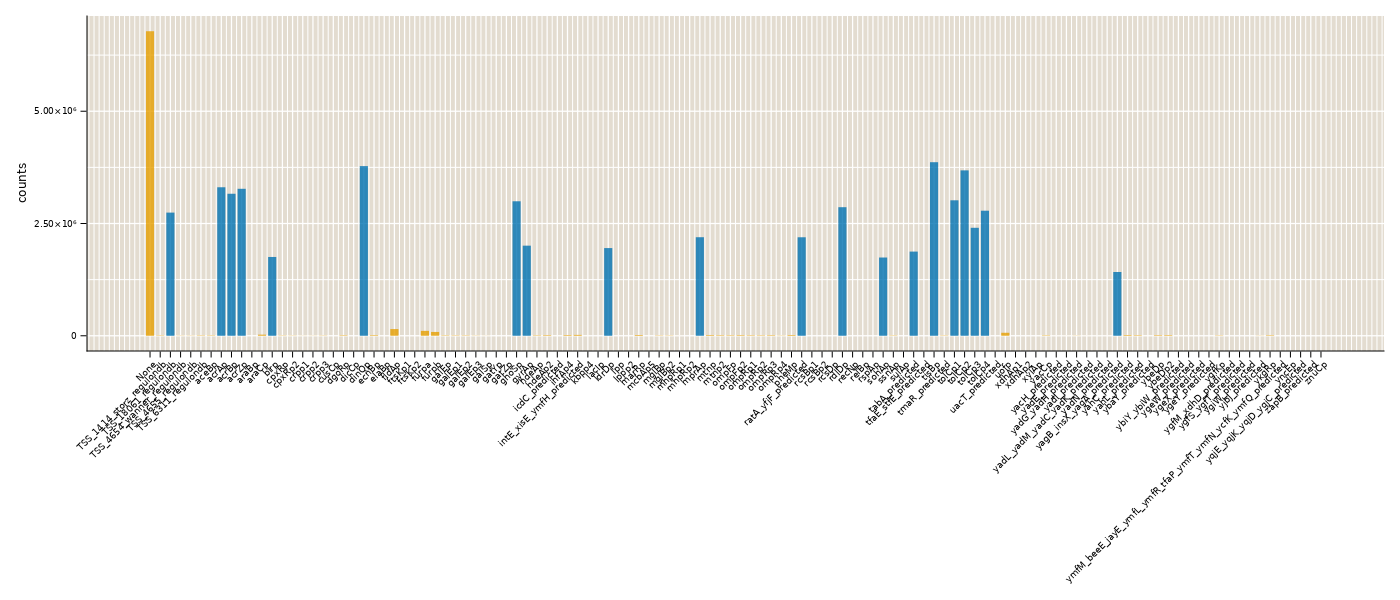

In [18]:
df_per_promoter_201 = combine(groupby(df_filt_201, [:name, :rev_primer3]), :counts => sum => :counts)
sort!(df_per_promoter_201, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])

barplot!(
    ax, 
    1:nrow(df_per_promoter_201), 
    df_per_promoter_201.counts .* map(x -> x[1] == 201, df_per_promoter_201.rev_primer3)
)

barplot!(
    ax, 
    1:nrow(df_per_promoter_201), 
    df_per_promoter_201.counts .* map(x -> x[1] != 201, df_per_promoter_201.rev_primer3)
)

ax.xticks = (1:nrow(df_per_promoter_201), df_per_promoter_201.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

Now only for the subpool.

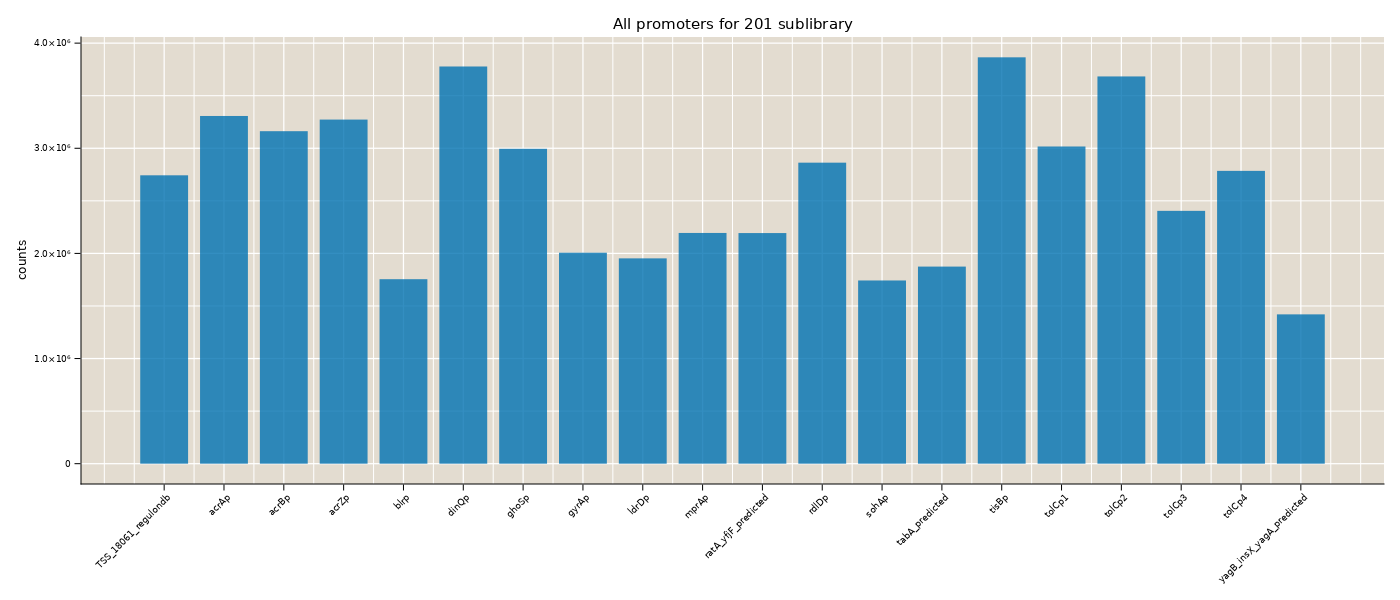

In [19]:
df_per_promoter_201_only = df_per_promoter_201[map(x -> x[1] == 201, df_per_promoter_201.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_201_only), 
    df_per_promoter_201_only.counts,
)

ax.xticks = (1:nrow(df_per_promoter_201_only), df_per_promoter_201_only.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"
ax.title = "All promoters for 201 sublibrary"
ax.titlesize=15

fig

### Mean number of barcodes per variant

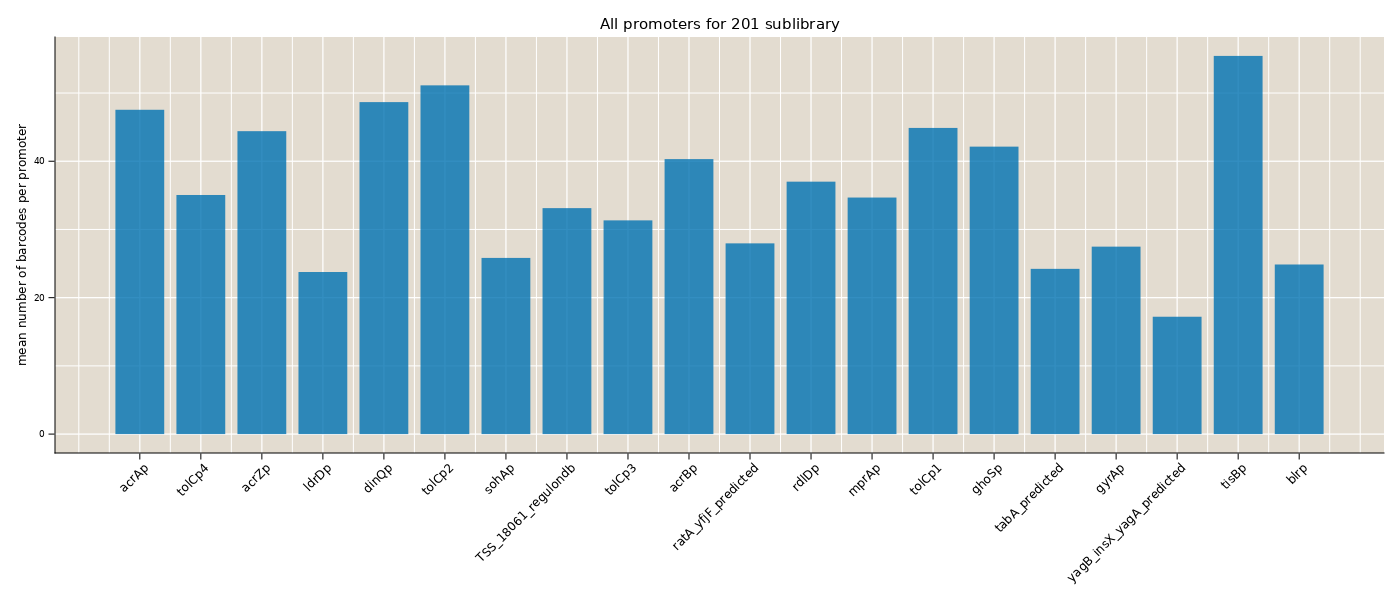

In [20]:
df_mean_barcodes_201 = combine(
    groupby(
        combine(
            groupby(
                df_filt_201, 
                [:promoter, :name, :rev_primer3]
                ), 
            nrow
            ), 
        [:name, :rev_primer3]
        ), 
    :nrow => mean => :mean_barcodes
)

df_mean_barcodes_201 = df_mean_barcodes_201[map(x -> x[1] == 201, df_mean_barcodes_201.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
ax.xticklabelsize = 12
barplot!(
    ax, 
    1:nrow(df_mean_barcodes_201), 
    df_mean_barcodes_201.mean_barcodes,
)

ax.xticks = (1:nrow(df_mean_barcodes_201), df_mean_barcodes_201.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "mean number of barcodes per promoter"
ax.title = "All promoters for 201 sublibrary"
ax.titlesize = 15

fig

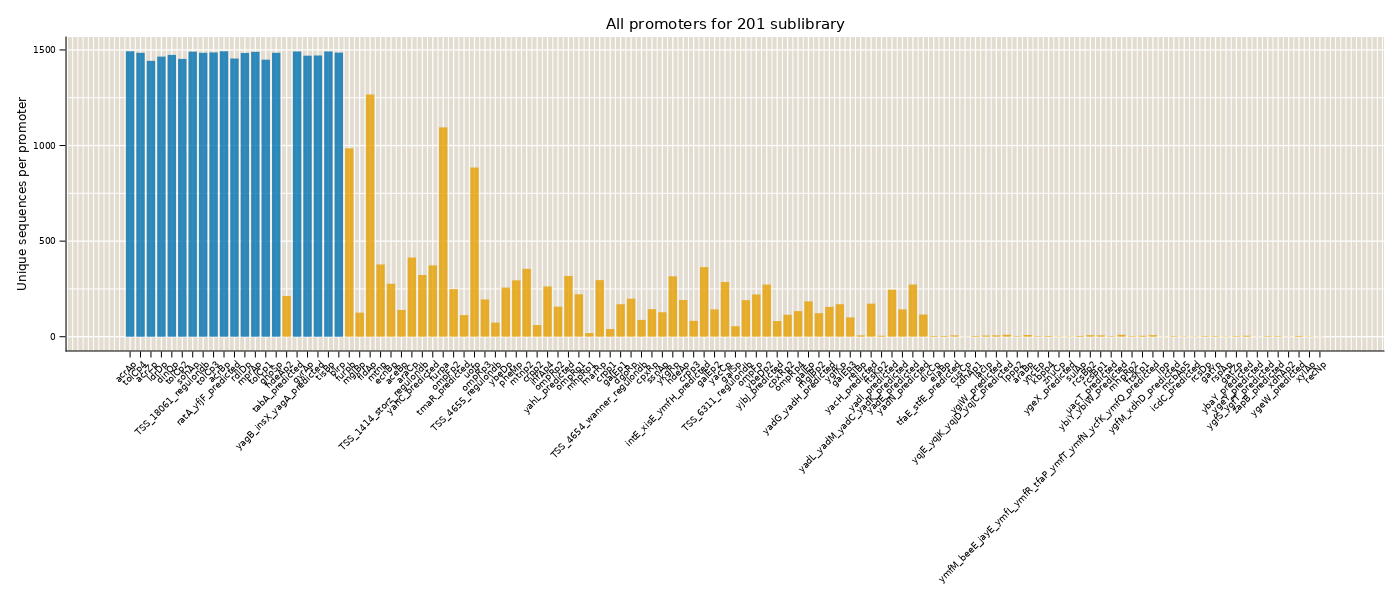

In [21]:
df_unique_per_prom_201 = combine(groupby(df_filt_201, [:name, :rev_primer3]), :promoter => num_unique);
df_unique_per_prom_201 = df_unique_per_prom_201[df_unique_per_prom_201.name .!= "None", :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_201), 
    df_unique_per_prom_201.promoter_num_unique .* map(x -> x[1] == 201, df_unique_per_prom_201.rev_primer3),
)

barplot!(
    ax, 
    1:nrow(df_unique_per_prom_201), 
    df_unique_per_prom_201.promoter_num_unique .* map(x -> x[1] != 201, df_unique_per_prom_201.rev_primer3),
)

ax.xticks = (1:nrow(df_unique_per_prom_201), df_unique_per_prom_201.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "Unique sequences per promoter"
ax.title = "All promoters for 201 sublibrary"
ax.titlesize=15
save("../../../figures/seq_per_prom_201.pdf", fig)
fig

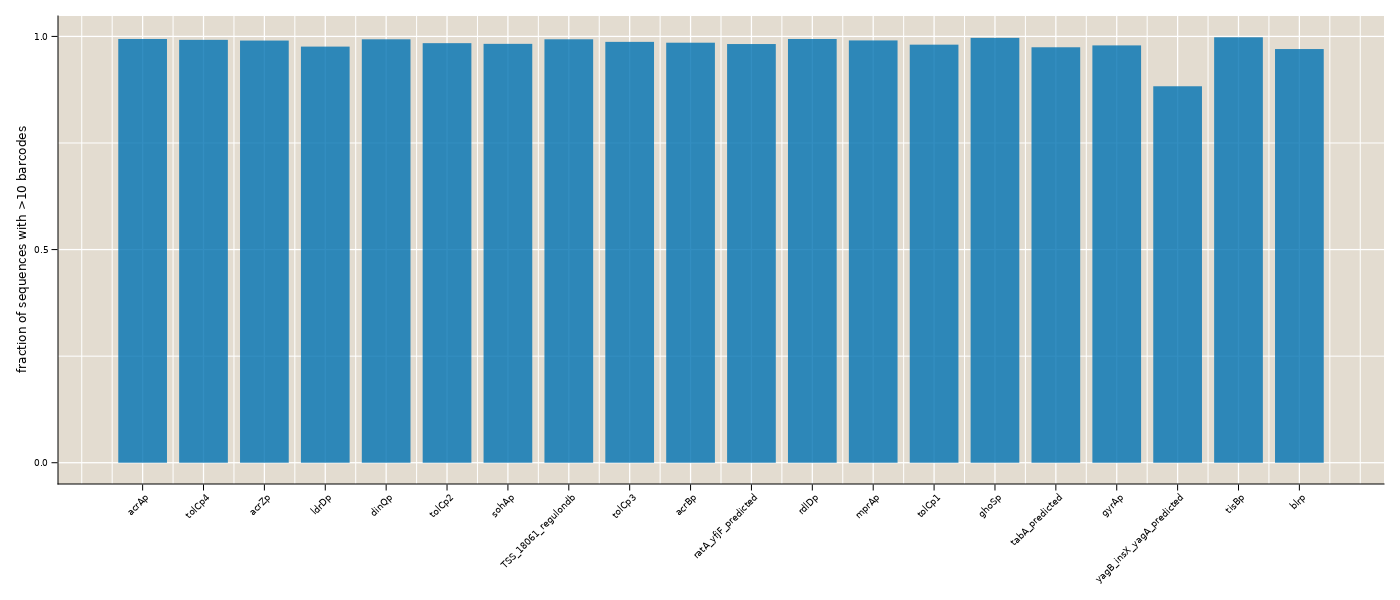

In [22]:
df_barcodes_thresh_201 = combine(
    groupby(
        df_filt_201, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)
df_barcodes_thresh_201 = df_barcodes_thresh_201[map(x -> x[1] == 201, df_barcodes_thresh_201.rev_primer3), :]

insertcols!(df_barcodes_thresh_201, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_201.nrow))
df_barcodes_thresh_201 = combine(
    groupby(
        df_barcodes_thresh_201, 
        [:name, :rev_primer3, :rev_primer2]
    ), 
    :thresh => mean => :fraction_passed
)      

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_barcodes_thresh_201), 
    df_barcodes_thresh_201.fraction_passed,
)

ax.xticks = (1:nrow(df_barcodes_thresh_201), df_barcodes_thresh_201.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "fraction of sequences with >10 barcodes"

fig

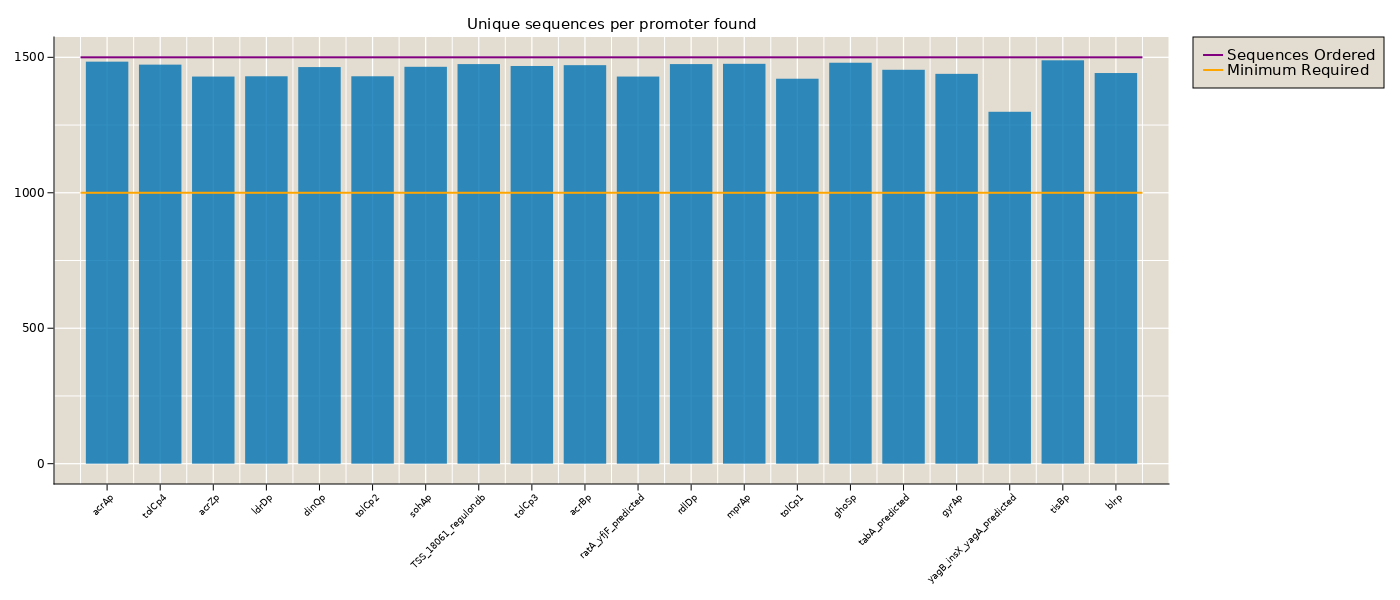

In [23]:
df_barcodes_thresh_201 = combine(
    groupby(
        df_filt_201, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)
df_barcodes_thresh_201 = df_barcodes_thresh_201[map(x -> x[1] == 201, df_barcodes_thresh_201.rev_primer3), :]
df_barcodes_thresh_201 = df_barcodes_thresh_201[df_barcodes_thresh_201.name .!= "None", :]

insertcols!(df_barcodes_thresh_201, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_201.nrow))

df_barcodes_thresh_201 = df_barcodes_thresh_201[df_barcodes_thresh_201.thresh .== 1, :]

df_unique_per_prom_201 = combine(groupby(df_barcodes_thresh_201, :name), :promoter => num_unique);
df_unique_per_prom_201 = df_unique_per_prom_201[df_unique_per_prom_201.name .!= "None", :]
df_unique_per_prom_201 = df_unique_per_prom_201[df_unique_per_prom_201.name .!= "None", :]


fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_201), 
    df_unique_per_prom_201.promoter_num_unique,
)

ax.xticks = (1:nrow(df_unique_per_prom_201), df_unique_per_prom_201.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
#ax.ylabel = "Unique sequences per promoter"
ax.title = "Unique sequences per promoter found"
ax.titlesize=15
xlims!(0, nrow(df_unique_per_prom_201)+1)

maxi = lines!(ax, [0.5, nrow(df_unique_per_prom_201)+0.5], [1500, 1500], color="purple", linewidth=2)
mini = lines!(ax, [0.5, nrow(df_unique_per_prom_201)+0.5], [1000, 1000], color="orange", linewidth=2)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)

fig

In [24]:
df_per_p3 = combine(groupby(df_filt_201, :rev_primer3), :counts => sum => :counts)

,rev_primer3,counts
,Tuple…,Int64
1,"(201, (212, 230))",53015619
2,"(0, (0, 0))",6781524
3,"(203, (212, 230))",58083
4,"(205, (212, 230))",439191
5,"(204, (212, 230))",90955
6,"(202, (212, 230))",61859
7,"(208, (212, 230))",135729
8,"(207, (212, 230))",38090
9,"(206, (212, 230))",26041


## Import Data 204

In [25]:
# Import data file
df_204 = CSV.read(
    "../../../data/barcodes/20220514_mapping/204_collapsed.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_204.barcode = map(x -> LongDNA{4}(x), df_204.barcode)
df_204.promoter = map(x -> LongDNA{4}(x), df_204.promoter)

# Display first lines
first(df_204, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,13465,ACTCCCAGTGTGTTACCTAA,GGCTGCTGATCCAACGCGGACGTGATTTGCGTGGCTAAGGCTATTTCCTCTCGTCTGGATTTGGGGGAGAGGAGTTGTGACGGCTATCACCCTTTACCAACAATGGTCAGGGTTGAGTGGTTTTCGGCGAAGAAGGAGGGCGTTGTTAGGTTGGGTACTT
2,12844,CACATTTATTATGTGGTGGC,GGGTTTGCACGAGGTGTTAATCTCTTTACAACAAAGCAACATAAAAAAGTGGCTGCATAGTTAAGGATGGTCTTTAGAGTGTTTCCCTCTGTAAAAACTTCGTTAATTCGCATGTTGATAATGACCTTTATCAACGAATCCCAAGATTCGTCAAAATTTT
3,11652,GGGTATGTGGGAATTCTGTC,AGGCGACATATAGCAATGACGTTGGTGCAATAAAAGATAGTTTAGCTAATATATCTATTCAAATTTGTGATAAACGTCAAAAAATTTGTTGACCGAACTGGTTATTTATAAAAGGGCACTTACGAAGTGGAGTCTTTTTTAAAGCTATGAAATACCAATG
4,11426,TGGCTGGGGGCTTTGCGGTA,GGTCCCTGATCCAACGTGGGCGAGGTTGGCCTAGCTAAGGCTAATTCGTCTCCCATGGATTTGGGGGAGATGAGTTTTGACGGCTATCACACTTTATCAACAATCGTCAGGGTAGGCTGCTTTTCGGCTAAGGAGGAAGGCGATGTTAGGTTGGTTGATT
5,11266,TCATGCCATTGCGTTGCAGT,GGATTTTGACAGGGTGTTAATTTGTTTACAAAAAAGCAACATAAAGAATGGGCTGAATCGTCATAGAGGGACTAGAGATTGTTTCCCTCCGCAAACACTTCGTTAATTCGCATGTTGATAATCATCTTTCTCAACGAATCCCATGATTAGTCAAAATTTA


### Filtering

Now we filter all barcode promoter combinations that occur more than 2.

In [26]:
df_filt_204 = df_204[df_204.counts .> 2, :]
last(df_filt_204, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTTATAACACAAAATATTCTAGAAAAACGGGGGGGGGGGGGGG
2,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTTATAACACAAAATATTCTAGAAAAACCGGGGGGGGGGGGGG
3,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTTATAACACAAAATATTCTACAAAAACCGGGGGGGGGGGGGG
4,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTAATAACACAAAATATTCTAGAAAAACGGGGGGGGGGGGGGG
5,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTAATAACACAAAATATTCTAGAAAAACCGGGGGGGGGGGGGG


### Identify promoters

Now we import the twist order to identify the sequences for each type.

In [27]:
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

for i in 1:nrow(df_filt_204)
    if df_filt_204.promoter[i] in keys(dict_twist_sequences)
        push!(name_list, dict_twist_sequences[df_filt_204.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_204.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_204.promoter[i]])
    else
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_204, 1, :name => name_list);
insertcols!(df_filt_204, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_204, 3, :rev_primer3 => primer3_list);

### Total counts per promoter

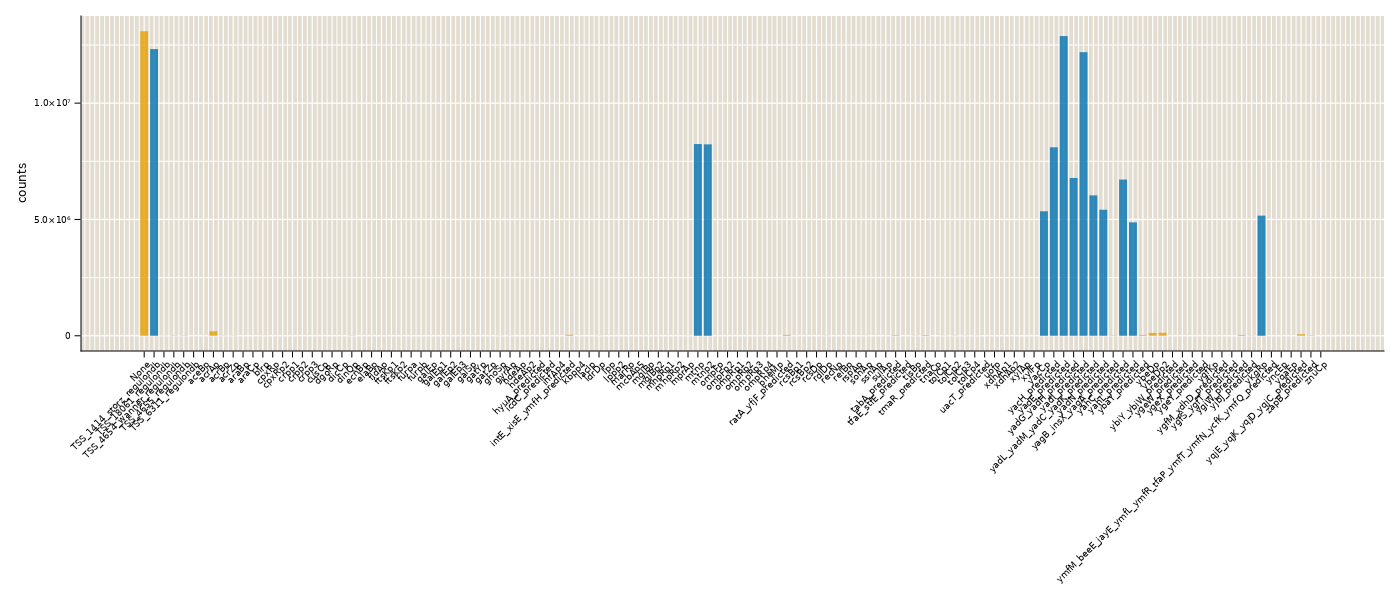

In [28]:
df_per_promoter_204 = combine(groupby(df_filt_204, [:name, :rev_primer3]), :counts => sum => :counts)
sort!(df_per_promoter_204, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_204), 
    df_per_promoter_204.counts .* map(x -> x[1] == 204, df_per_promoter_204.rev_primer3),
)
barplot!(
    ax, 
    1:nrow(df_per_promoter_204), 
    df_per_promoter_204.counts .* map(x -> x[1] != 204, df_per_promoter_204.rev_primer3),
)
ax.xticks = (1:nrow(df_per_promoter_204), df_per_promoter_204.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

Only for subpool.

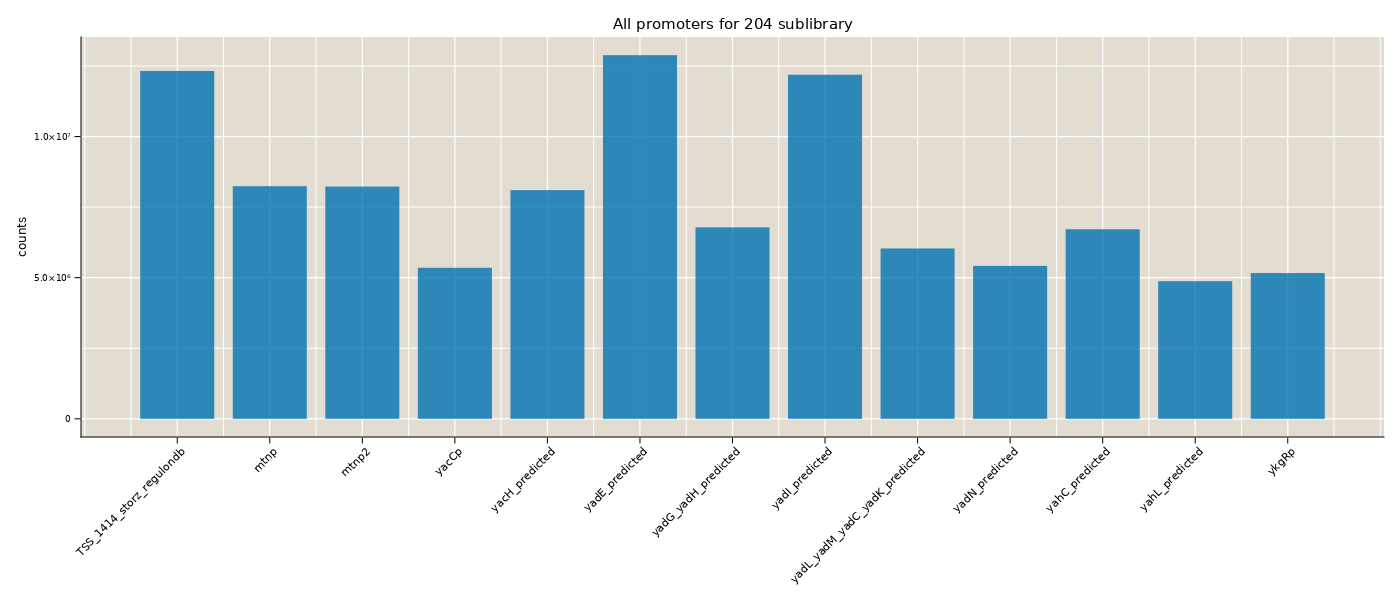

In [29]:
df_per_promoter_204_only = df_per_promoter_204[map(x -> x[1] == 204, df_per_promoter_204.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
ax.xticklabelsize=11

barplot!(
    ax, 
    1:nrow(df_per_promoter_204_only), 
    df_per_promoter_204_only.counts,
)

ax.xticks = (1:nrow(df_per_promoter_204_only), df_per_promoter_204_only.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"
ax.title = "All promoters for 204 sublibrary"
ax.titlesize=15

fig

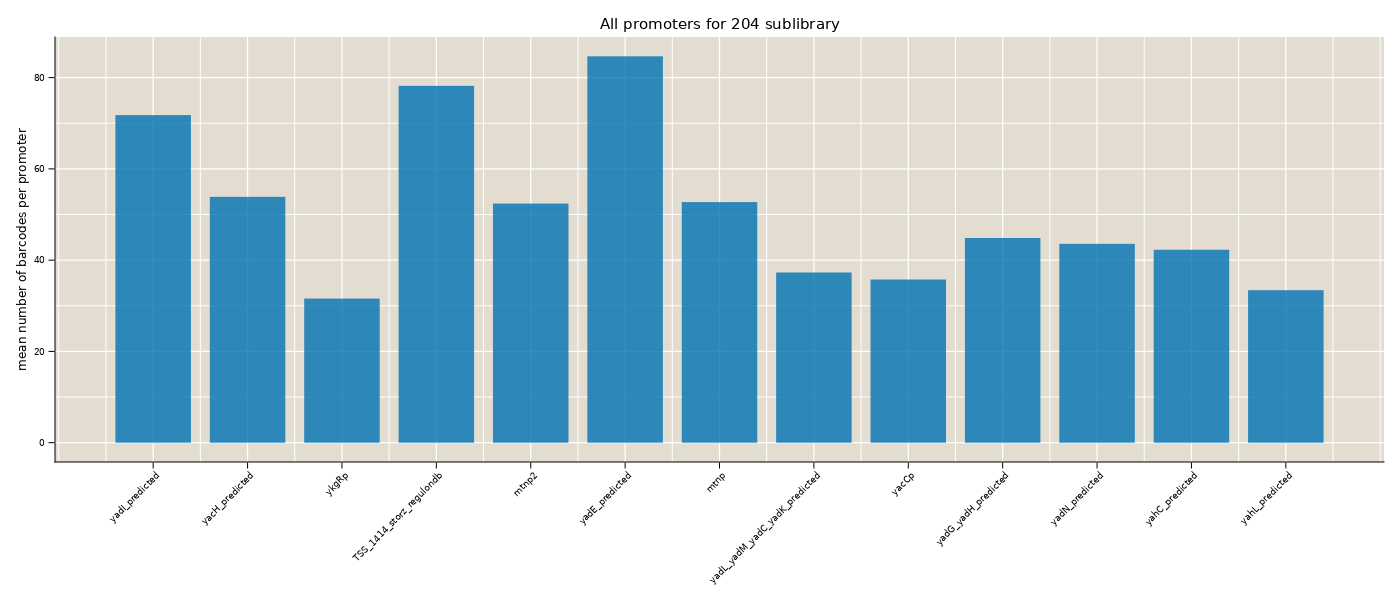

In [30]:
df_mean_barcodes_204 = combine(
    groupby(
        combine(
            groupby(
                df_filt_204, 
                [:promoter, :name, :rev_primer3]
                ), 
            nrow
            ), 
        [:name, :rev_primer3]
        ), 
    :nrow => mean => :mean_barcodes
)

df_mean_barcodes_204 = df_mean_barcodes_204[map(x -> x[1] == 204, df_mean_barcodes_204.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_mean_barcodes_204), 
    df_mean_barcodes_204.mean_barcodes,
)

ax.xticks = (1:nrow(df_mean_barcodes_204), df_mean_barcodes_204.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "mean number of barcodes per promoter"
ax.title = "All promoters for 204 sublibrary"
ax.titlesize=15

fig

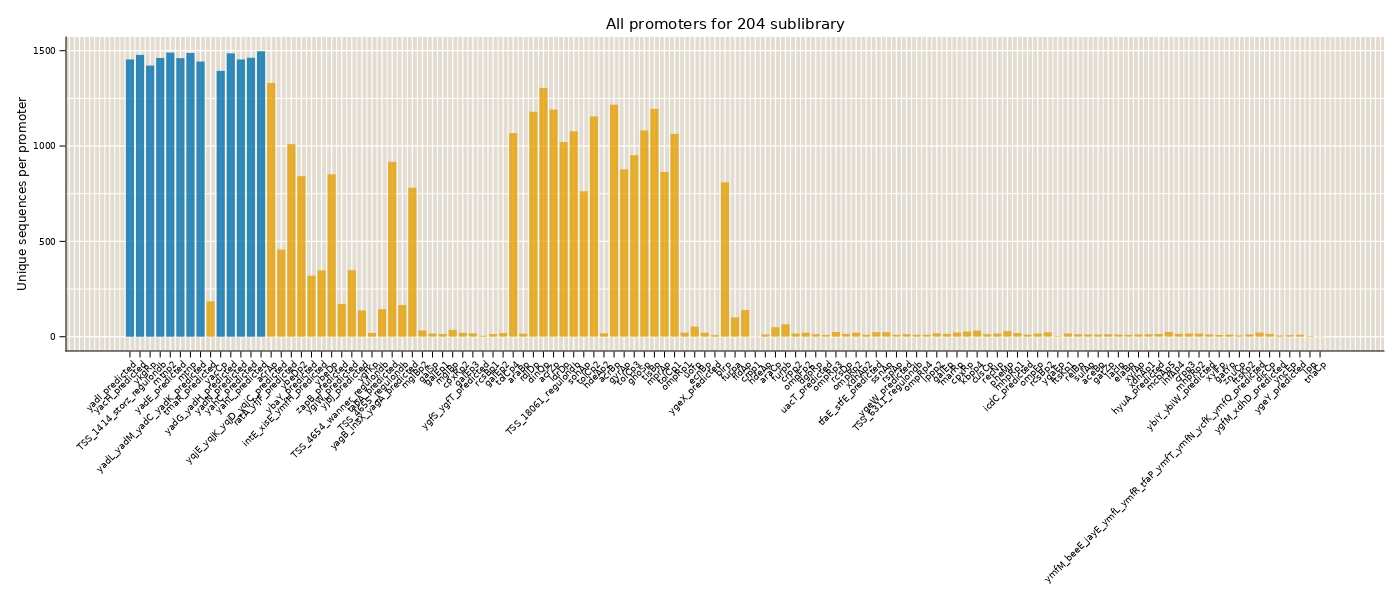

In [31]:
df_unique_per_prom_204 = combine(groupby(df_filt_204, [:name, :rev_primer3]), :promoter => num_unique);
df_unique_per_prom_204 = df_unique_per_prom_204[df_unique_per_prom_204.name .!= "None", :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_204), 
    df_unique_per_prom_204.promoter_num_unique .* map(x -> x[1] == 204, df_unique_per_prom_204.rev_primer3),
)

barplot!(
    ax, 
    1:nrow(df_unique_per_prom_204), 
    df_unique_per_prom_204.promoter_num_unique .* map(x -> x[1] != 204, df_unique_per_prom_204.rev_primer3),
)

ax.xticks = (1:nrow(df_unique_per_prom_204), df_unique_per_prom_204.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "Unique sequences per promoter"
ax.title = "All promoters for 204 sublibrary"
ax.titlesize=15
save("../../../figures/seq_per_prom_204.pdf", fig)
fig

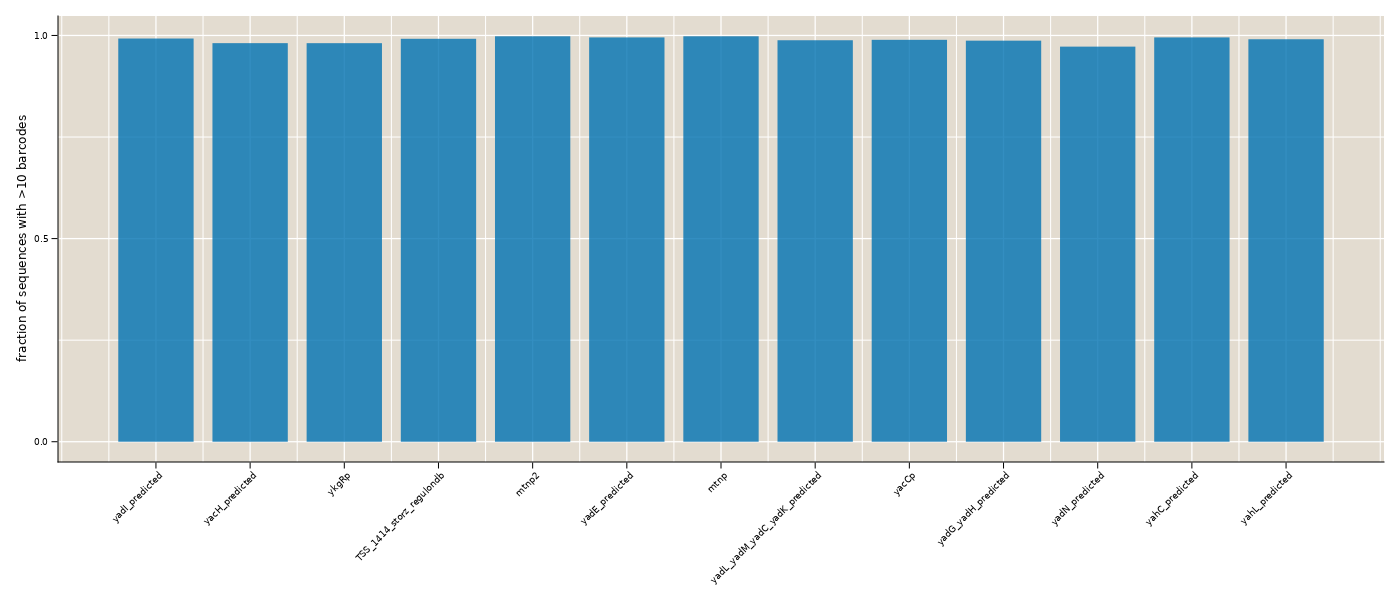

In [32]:
df_barcodes_thresh_204 = combine(
    groupby(
        df_filt_204, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)
df_barcodes_thresh_204 = df_barcodes_thresh_204[map(x -> x[1] == 204, df_barcodes_thresh_204.rev_primer3), :]

insertcols!(df_barcodes_thresh_204, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_204.nrow))
df_barcodes_thresh_204 = combine(
    groupby(
        df_barcodes_thresh_204, 
        [:name, :rev_primer3, :rev_primer2]
    ), 
    :thresh => mean => :fraction_passed
)      

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_barcodes_thresh_204), 
    df_barcodes_thresh_204.fraction_passed,
)

ax.xticks = (1:nrow(df_barcodes_thresh_204), df_barcodes_thresh_204.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "fraction of sequences with >10 barcodes"

fig

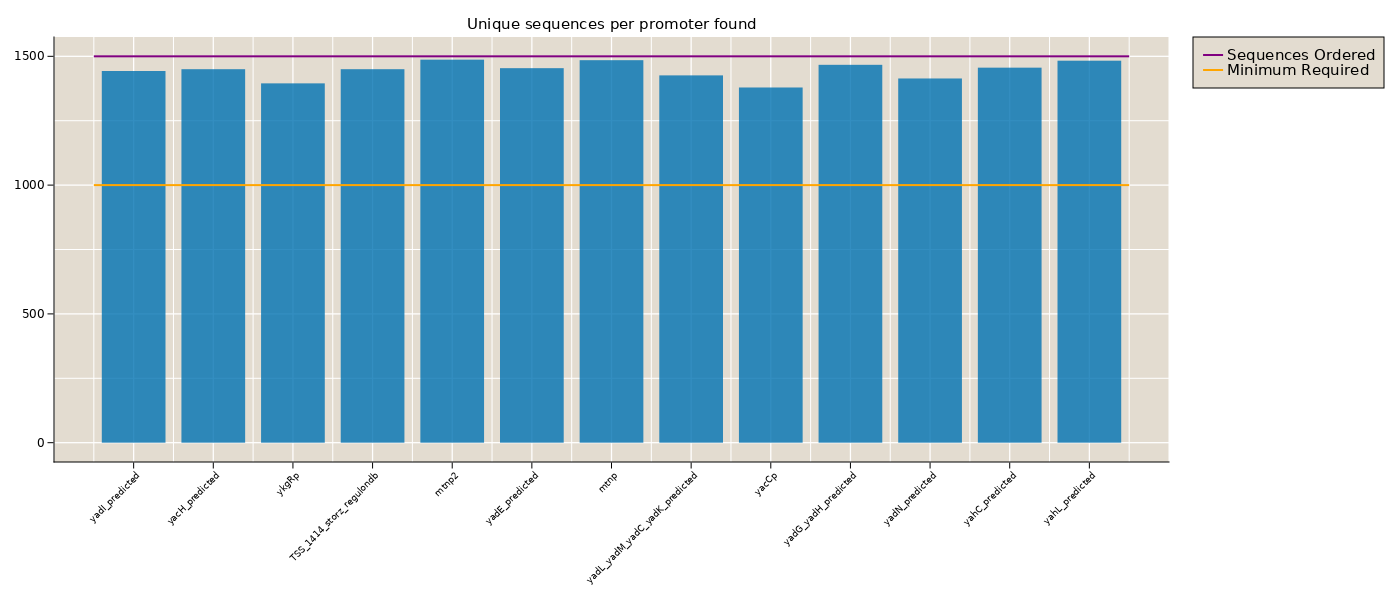

In [33]:
df_barcodes_thresh_204 = combine(
    groupby(
        df_filt_204, 
        [:promoter, :name, :rev_primer3]
    ), 
    nrow
)
df_barcodes_thresh_204 = df_barcodes_thresh_204[map(x -> x[1] == 204, df_barcodes_thresh_204.rev_primer3), :]
df_barcodes_thresh_204 = df_barcodes_thresh_204[df_barcodes_thresh_204.name .!= "None", :]

insertcols!(df_barcodes_thresh_204, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_204.nrow))
df_barcodes_thresh_204 = df_barcodes_thresh_204[df_barcodes_thresh_204.thresh .== 1, :]

df_unique_per_prom_204 = combine(groupby(df_barcodes_thresh_204, :name), :promoter => num_unique);
df_unique_per_prom_204 = df_unique_per_prom_204[df_unique_per_prom_204.name .!= "None", :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_204), 
    df_unique_per_prom_204.promoter_num_unique,
)

ax.xticks = (1:nrow(df_unique_per_prom_204), df_unique_per_prom_204.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
#ax.ylabel = "Unique sequences per promoter"
ax.title = "Unique sequences per promoter found"
ax.titlesize=15
xlims!(0, nrow(df_unique_per_prom_204)+1)

maxi = lines!(ax, [0.5, nrow(df_unique_per_prom_204)+0.5], [1500, 1500], color="purple", linewidth=2)
mini = lines!(ax, [0.5, nrow(df_unique_per_prom_204)+0.5], [1000, 1000], color="orange", linewidth=2)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)

fig

## Import Data for 100

Now we import the data for the subpool that contains all oligos.

In [34]:
# Import data file
df_100 = CSV.read(
    "../../../data/barcodes/20220514_mapping/100_collapsed_.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_100.barcode = map(x -> LongDNA{4}(x), df_100.barcode)
df_100.promoter = map(x -> LongDNA{4}(x), df_100.promoter)

# Display first lines
first(df_100, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,8971,TGTCCAGCCTAACTCAGCGT,AGGAGATATCATCGGCGTATCCTGTAAAGAAGGTGAAGTGACAGAAGGCATATTTGAAAAATACCGTATCGCTACATACATAGGAGCCAGCTGGAAGCCTTACATCATCGCCGCGATGATCCTTTCCCGTAAATATGCTAAACCAGTTGCACCTCTCGAG
2,8661,ATGGTCAGTAAAGAGTCTTG,AGCGGAGTTCCGTAGCCGGGGCAGCGTTTAAATTTCCACTTGCATGTAGCACAGAGTGCAGTCATGCTCGTTTGCTGATTCCGCAAGCCTGGCTGTTCTGCTATGATTGCCTTAATACCTGGGCGATTTTCCACCCCCATTTCAATAAGTTTCAAGAGGT
3,8483,AATCGTCTCTGGGAGTTGTA,CCGGAAGGTAACTTCTTCGGCAAATTCATTGATTACATTAAATTAATGTTCCATGACTGGTTGAGTTAAAAACTAAACACTTGAAAGTGTAATTTCCGTCCCGATAGTCGATGCATCAGGAAAAAAGTCACGCCTTCTGGCGGGAGTTGTTATTGGATTA
4,7874,CCCCGAGGCCGACCTATGAA,CCAGAAGGTAACTTCTTCGGCATAATCATTGATTACATAAAATTAATATTCTTTCACTGGTTTGGTAAAAAATTAAACACTTGAAAGTGGAGTGTCCGGCCCCATATACTAGGCATCAGTAAAAAACTCCCGCCTTCTGGGGGGAGTGGCTGTTTAATTG
5,7097,GCCACGAACAGATTGTAAAG,GCCTGCATAACAATGTCCTGGCAAATGTCTTATTGTGAAGGAAACCGAACGCCACGCAAACCGGACCGGACAACAGTGGAGAACTTTACTGTCCTTAGCGGTTAGGATAGCCTCTTGACTATATCTGGAGTTGACCATGTTAGAGTTATTAATAAGTCTG


## Filtering

Now we filter all barcode promoter combinations that occur more than 2.

In [35]:
df_filt_100 = df_100[df_100.counts .> 2, :]
last(df_filt_100, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAAAATAGATTAGTAG,GTGCGTTGGCCTATGGACTAGCCCGGAAGGGGATGACGATTATATAACCCACAAGAATCATTTTTCTACAACAATACATTTACTTTATTTGTCACTGTCGGTACTACATCGGGTGAAATTAATGAGGTAATTACCAAGTGGATAGTTCGTTTGGCCCGCA
2,3,AAAAAAAAACTGTAAGTAAT,CAGGTTGTCGGGCTTAAGCATTGTTAATGTCCTAGTACTAATAGTGAATTAAATGCGAATTTCAACAACGTTTGACTGCCGTTTGAGCAGTCACGTATTAAATTCAGGCACCTGAACGCCCTATGCCACGTAACGCCAAGATTCTGCGGTTGCGGCTTCT
3,3,AAAAAAAAAATAGATTAGTC,GTGCGTTGGCCTATGGACTAGCCCGGAAGGGGATGACGATTATATAACCCACAAGAATCATTTTTCTACAACAATACATTTACTTTATTTGTCACTGTCGGTACTACATCGGGTGAAATTAATGAGGTAATTACCAAGTGGATAGTTCGTTTGGCCCGCA
4,3,AAAAAAAAAAGGCTGGGGAA,GTTTCGGGTCTTTCCCTGAGACGGAGGTCTATGAAGAAGAGGGTATCCCACACATTGGCAGGGCACGCGAGGTAATTCAGGCGTAGTCAACAAACCTTGTCTATAGTGAGTGACAAGCTTTACGCAAATGGGGCACGACAATGTCTAATCAGTTTGGGGA
5,3,AAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA


## Identify promoters

Now we import the twist order to identify the sequences for each type.

In [36]:
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

for i in 1:nrow(df_filt_100)
    if df_filt_100.promoter[i] in keys(dict_twist_sequences)
        push!(name_list, dict_twist_sequences[df_filt_100.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_100.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_100.promoter[i]])
    else
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_100, 1, :name => name_list);
insertcols!(df_filt_100, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_100, 3, :rev_primer3 => primer3_list);

Plot number of counts across promoters.

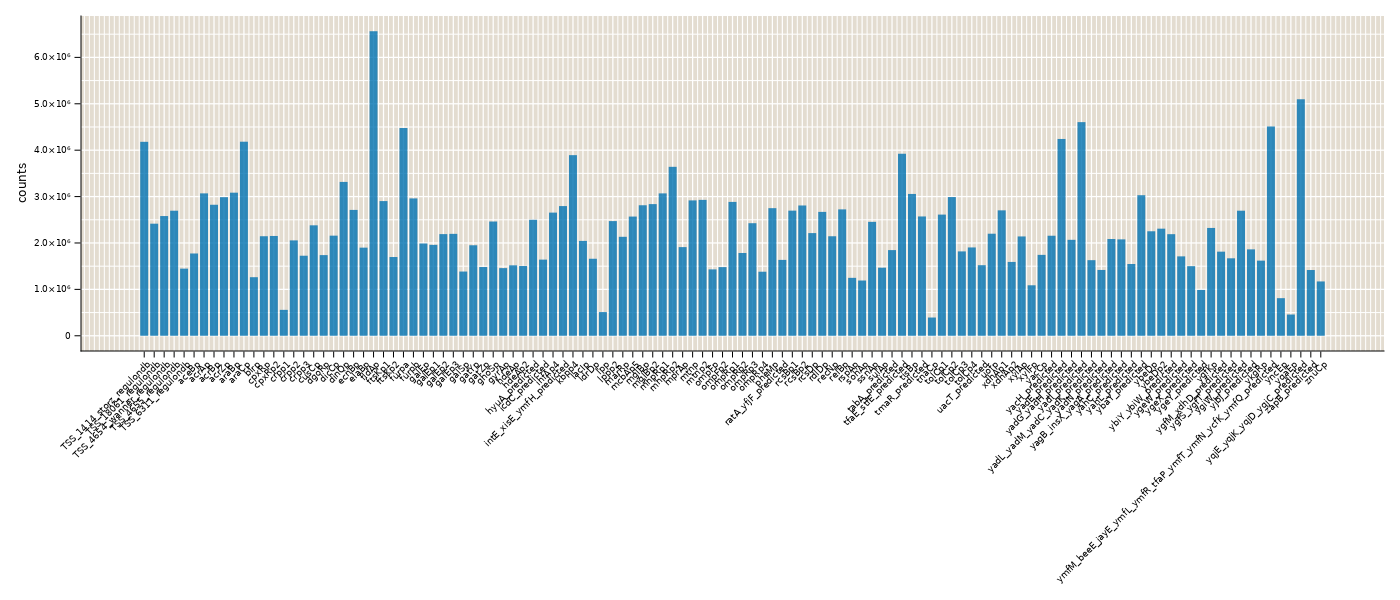

In [37]:
df_per_promoter_100 = combine(groupby(df_filt_100, [:name, :rev_primer3, :rev_primer2]), :counts => sum => :counts)
df_per_promoter_100 = df_per_promoter_100[df_per_promoter_100.name .!= "None", :]
sort!(df_per_promoter_100, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_100), 
    df_per_promoter_100.counts,
)

ax.xticks = (1:nrow(df_per_promoter_100), df_per_promoter_100.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

Compute mean number of barcodes per promoter variant.

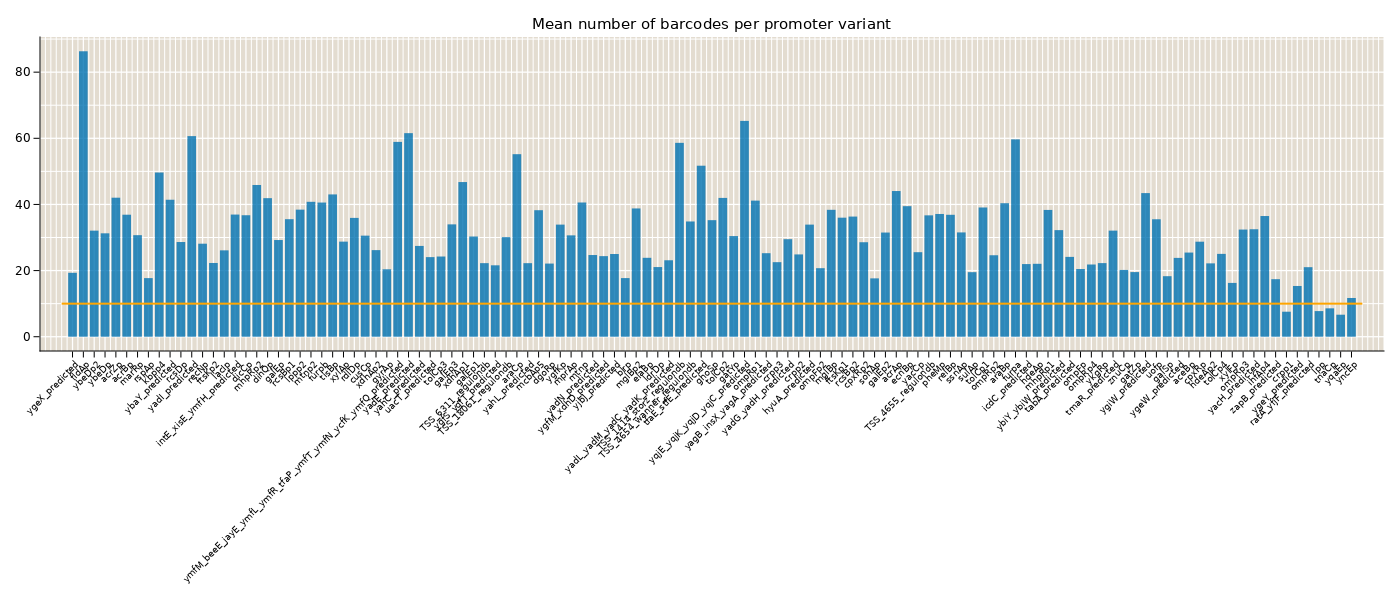

In [38]:
df_mean_barcodes_100 = combine(
    groupby(
        combine(
            groupby(
                df_filt_100, 
                [:promoter, :name, :rev_primer2, :rev_primer3]
                ), 
            nrow
            ), 
        [:name, :rev_primer2, :rev_primer3]
        ), 
    :nrow => mean => :mean_barcodes
)

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
df_mean_barcodes_100 = df_mean_barcodes_100[df_mean_barcodes_100.name .!= "None", :]
barplot!(
    ax, 
    1:nrow(df_mean_barcodes_100), 
    df_mean_barcodes_100.mean_barcodes,
)
ax.yticklabelsize = 12
ax.titlesize=15

xlims!(-2, nrow(df_mean_barcodes_100)+3)
ax.xticks = (1:nrow(df_mean_barcodes_100), df_mean_barcodes_100.name)

mini = lines!(ax, [0, nrow(df_mean_barcodes_100)+1], [10, 10], color="orange", linewidth=2)
ax.xticklabelrotation = pi/4
ax.title = "Mean number of barcodes per promoter variant"

save("../../../figures/bc_per_prom_100.pdf", fig)
fig

Find fraction of promoter variants that have more than or equally to 10 counts.

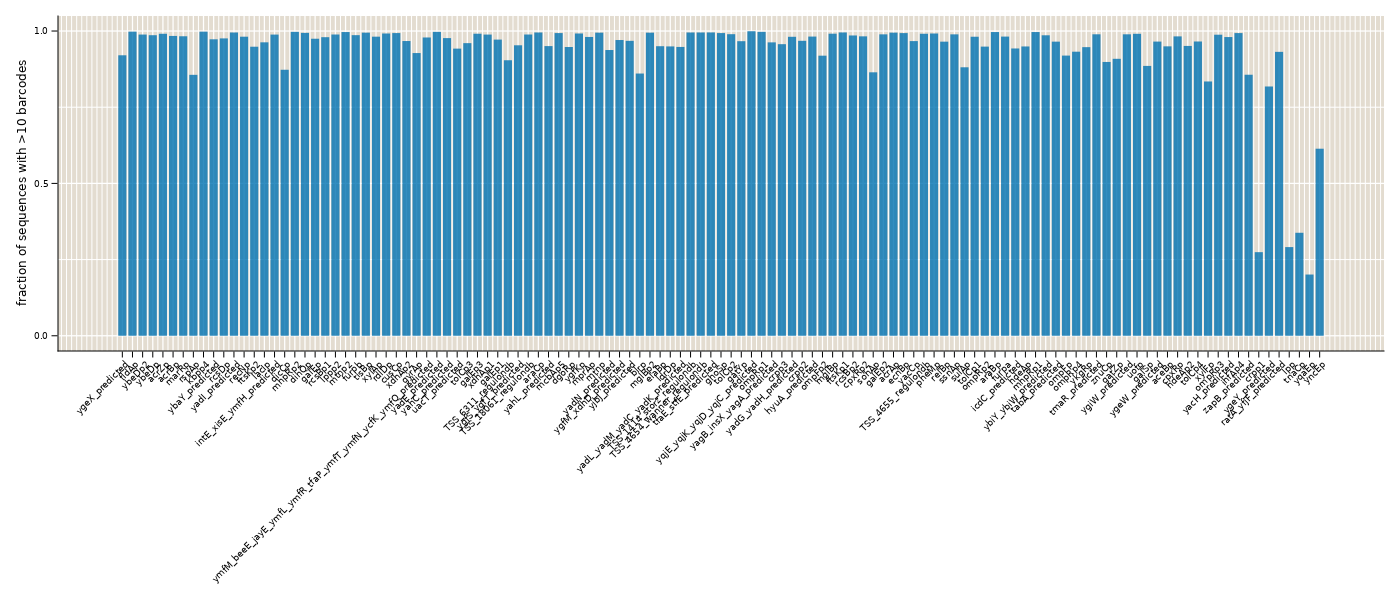

In [39]:
df_barcodes_thresh_100 = combine(
    groupby(
        df_filt_100, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)

df_barcodes_thresh_100 = df_barcodes_thresh_100[df_barcodes_thresh_100.name .!= "None", :]

insertcols!(df_barcodes_thresh_100, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_100.nrow))
df_barcodes_thresh_100 = combine(
    groupby(
        df_barcodes_thresh_100, 
        [:name, :rev_primer3, :rev_primer2]
    ), 
    :thresh => mean => :fraction_passed
)      

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_barcodes_thresh_100), 
    df_barcodes_thresh_100.fraction_passed,
)

ax.xticks = (1:nrow(df_barcodes_thresh_100), df_barcodes_thresh_100.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "fraction of sequences with >10 barcodes"
save("../../../figures/100_fraction_bc_thresh.pdf", fig)
fig

In [40]:
df_barcodes_thresh_100[
    map(
        x -> x in ["yqaEp", "crpp1", "lpp", "tnaCp", "yncEp"], 
        df_barcodes_thresh_100.name
        ),
    :]

,name,rev_primer3,rev_primer2,fraction_passed
,String,Tuple…,Tuple…,Float64
1,crpp1,"(208, (212, 230))","(105, (193, 211))",0.274373
2,lpp,"(203, (212, 230))","(107, (193, 211))",0.290984
3,tnaCp,"(203, (212, 230))","(107, (193, 211))",0.337999
4,yqaEp,"(207, (212, 230))","(108, (193, 211))",0.20095
5,yncEp,"(207, (212, 230))","(108, (193, 211))",0.613835


In [41]:
df_barcodes_thresh_100 = combine(
    groupby(
        df_filt_100, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)

df_barcodes_thresh_100 = df_barcodes_thresh_100[df_barcodes_thresh_100.name .!= "None", :]

insertcols!(df_barcodes_thresh_100, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_100.nrow))
df_barcodes_thresh_100 = df_barcodes_thresh_100[df_barcodes_thresh_100.thresh .== 1, :]

df_unique_per_prom_100 = combine(groupby(df_barcodes_thresh_100, :name), :promoter => num_unique);
df_unique_per_prom_100 = df_unique_per_prom_100[df_unique_per_prom_100.name .!= "None", :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_100), 
    df_unique_per_prom_100.promoter_num_unique,
)

ax.xticks = (1:nrow(df_unique_per_prom_100), df_unique_per_prom_100.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
#ax.ylabel = "Unique sequences per promoter"
ax.title = "Unique sequences per promoter with at least 10 barcodes"
ax.titlesize=15
xlims!(-2, nrow(df_unique_per_prom_100)+3)

maxi = lines!(ax, [0, nrow(df_unique_per_prom_100)+1], [1500, 1500], color="purple", linewidth=2)
mini = lines!(ax, [0, nrow(df_unique_per_prom_100)+1], [1000, 1000], color="orange", linewidth=2)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)
save("../../../figures/")
fig

LoadError: No applicable_savers found for UNKNOWN

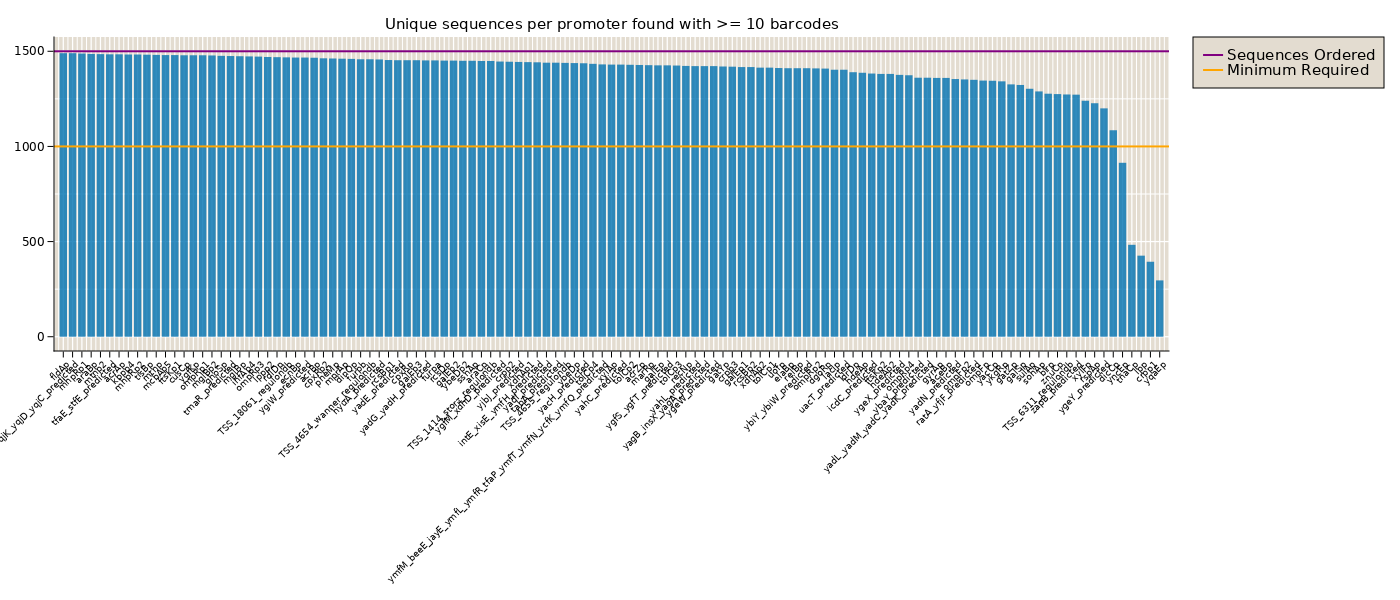

In [128]:
df_barcodes_thresh_100 = combine(
    groupby(
        df_filt_100, 
        [:promoter, :name, :rev_primer3, :rev_primer2]
    ), 
    nrow
)


#df_barcodes_thresh_100 = df_barcodes_thresh_100[map(x -> x[1] == 107, df_barcodes_thresh_100.rev_primer2), :]
df_barcodes_thresh_100 = df_barcodes_thresh_100[df_barcodes_thresh_100.name .!= "None", :]

insertcols!(df_barcodes_thresh_100, 1, :thresh => map(x -> x > 9, df_barcodes_thresh_100.nrow))
df_barcodes_thresh_100 = df_barcodes_thresh_100[df_barcodes_thresh_100.thresh .== 1, :]

df_unique_per_prom_100 = combine(groupby(df_barcodes_thresh_100, :name), :promoter => num_unique);
df_unique_per_prom_100 = df_unique_per_prom_100[df_unique_per_prom_100.name .!= "None", :]
sort!(df_unique_per_prom_100, :promoter_num_unique, rev=true)

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_100), 
    df_unique_per_prom_100.promoter_num_unique,
)

ax.xticks = (1:nrow(df_unique_per_prom_100), df_unique_per_prom_100.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
#ax.ylabel = "Unique sequences per promoter"
ax.title = "Unique sequences per promoter found with >= 10 barcodes"
ax.titlesize=15
xlims!(0, nrow(df_unique_per_prom_100)+1)

maxi = lines!(ax, [0, nrow(df_unique_per_prom_100)+1], [1500, 1500], color="purple", linewidth=2)
mini = lines!(ax, [0, nrow(df_unique_per_prom_100)+1], [1000, 1000], color="orange", linewidth=2)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)

save("../../../figures/unique_seq_prom_10bc.pdf", fig)

fig

yqaEp: TATTTTCTAAATTAAGTAAACTCTAAACTAAAAATGCAACATATACCAGCCTCAGCAGCGTAAATGAGAGTAAAAGCGTAAGCTGAAACTGGCAGGCTCCGCTAAAATTACTACGCTTAAGAGATAAAATCTCTTTTTAAACAATGAGTAATTTTCTTAT


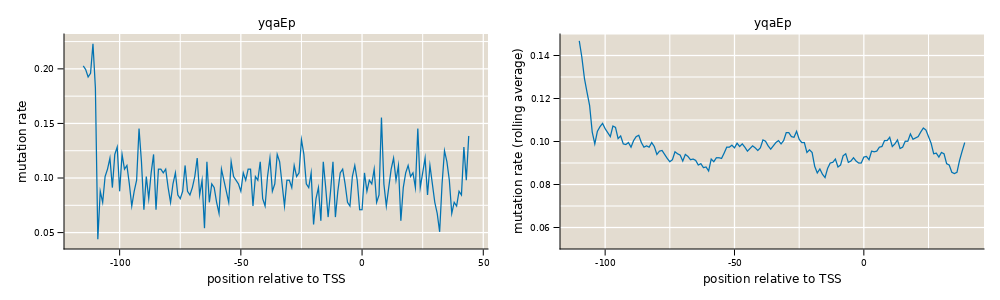

crpp1: AATTTTCCTGACAGAGTACGCGTACTAACCAAATCGCGCAACGGAAGGCGACCTGGGTCATGCTGAAGCGAGACACCAGGAGACACAAAGCGAAAGCTATGCTAAAACAGTCAGGATGCTACAGTAATACATTGATGTACTGCATGTATGCAAAGGACGT


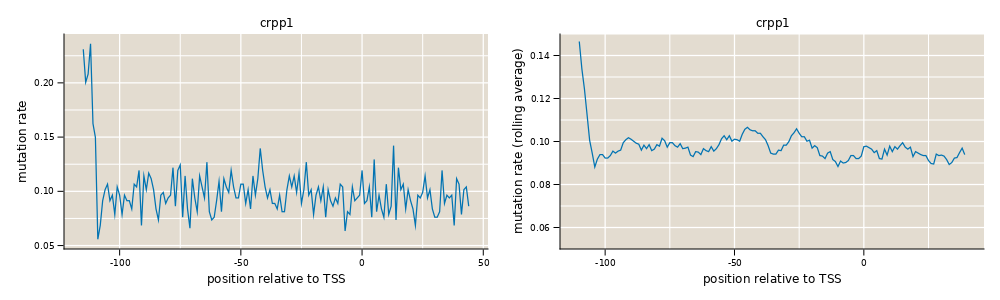

lpp: TTTTTTTATCTAAAACCCAGCGTTCGATGCTTCTTTGAGCGAACGATCAAAAATAAGTGCCTTCCCATCAAAAAAATATTCTCAACATAAAAAACTTTGTGTAATACTTGTAACGCTACATGGAGATTAACTCAATCTAGAGGGTATTAATAATGAAAGC


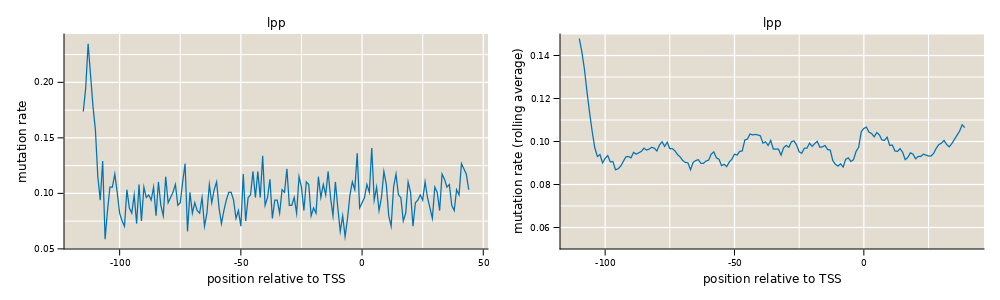

tnaCp: AATTTATAATCTTTAAAAAAAGCATTTAATATTGCTCCCCGAACGATTGTGATTCGATTCACATTTAAACAATTTCAGAATAGACAAAAACTCTGAGTGTAATAATGTAGCCTCGTGTCTTGCGAGGATAAGTGCATTATGAATATCTTACATATATGTG


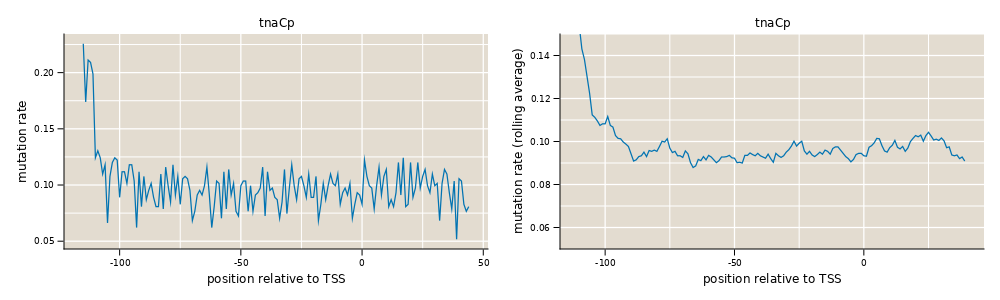

yncEp: TTGTAAATTTATGGAAAATGAAACGGCACAATACGTTAAGTAATTGAGAAAATTGTAGTCGTAACGGCAAGAAATGCTCCACATTTGAGAAAATAATGATTACCATTCCCATTTATAACAAGAGCGTAACGATGATTACGCTTAGCGAAGCATTGTGAAG


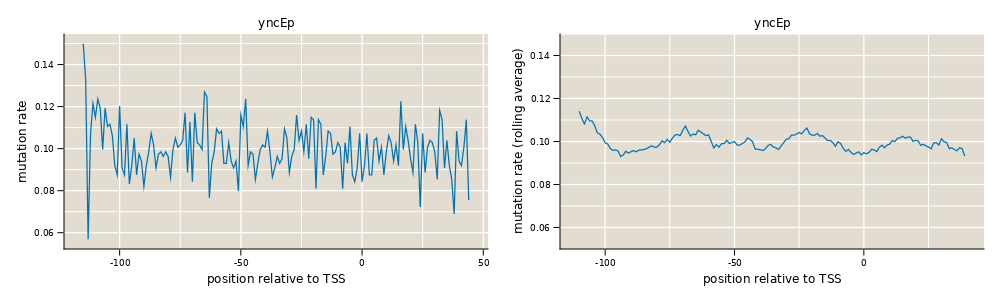

dicCp: GAGGTTTTTCCGACGATACCTGATGCGTTCGCCGATAGTTAAATTTTTTGTTTCCATAGTTAGCTAATGCTAAATCGTATTGACTATGTTTTTGTTAACATCTATCTTGTTAGTTATGACTAACAATAAAGGTGTTTTAAATGCTTAAAACTGACGCTCT


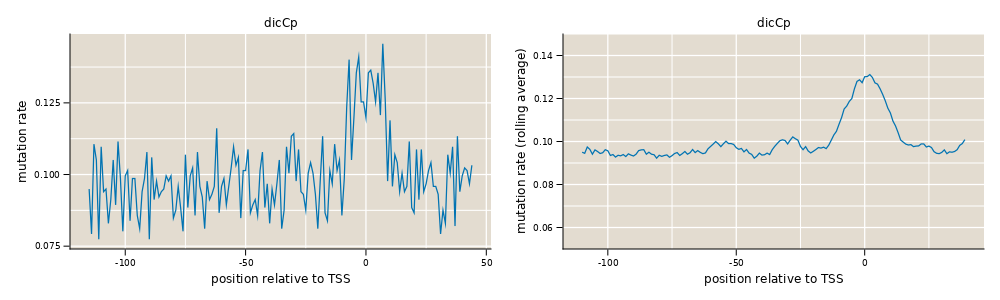

galEp1: CTGTTTTATAATCACTTAATCGCGCATAAAAAACGGCTAAATTCTTGTGTAAACGATTCCACTAATTTATTCCATGTCACACTTTTCGCATCTTTGTTATGCTATGGTTATTTCATACCATAAGCCTAATGGAGCGAATTATGAGAGTTCTGGTTACCGG


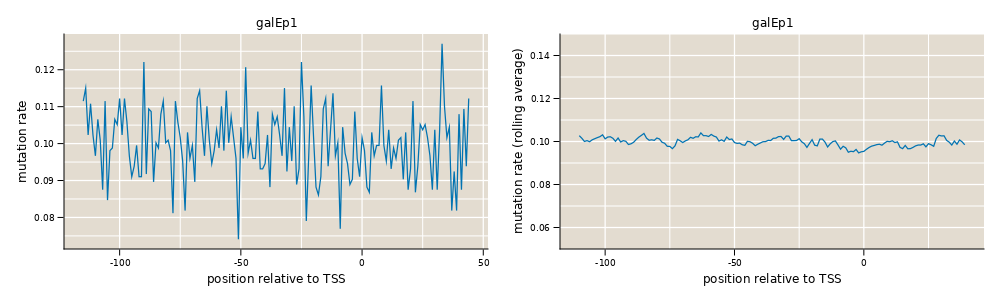

marRp: CTCTTTAGCTAGCCTTGCATCGCATTGAACAAAACTTGAACCGATTTAGCAAAACGTGGCATCGGTCAATTCATTCATTTGACTTATACTTGCCTGGGCAATATTATCCCCTGCAACTAATTACTTGCCAGGGCAACTAATGTGAAAAGTACCAGCGATC


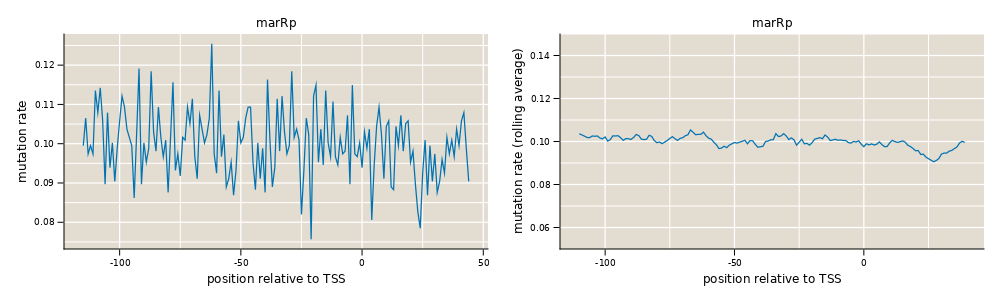

acrAp: CGAGGATGTGTTGGCGCGTTTCTTGCGCTTCTTGTTTGGTTTTTCGTGCCATATGTTCGTGAATTTACAGGCGTTAGATTTACATACATTTGTGAATGTATGTACCATAGCACGACGATAATATAAACGCAGCAATGGGTTTATTAACTTTTGACCATTG


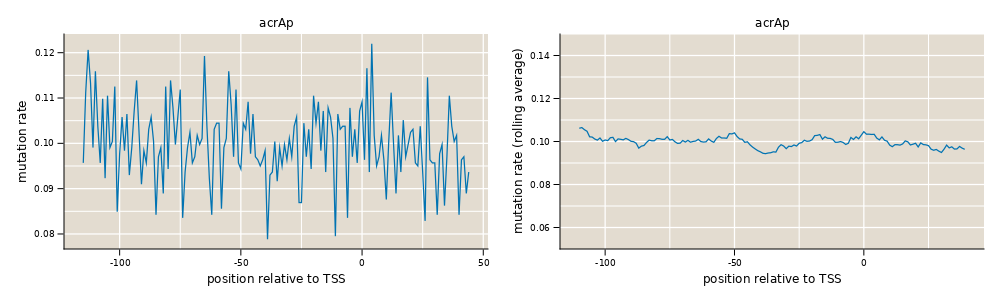

In [151]:
proms = ["yqaEp", "crpp1", "lpp", "tnaCp", "yncEp", "dicCp", "galEp1", "marRp", "acrAp"]
for prom in proms
    seq = df_seqs[df_seqs.promoter .== prom, :sequence][1][27:186]
    println(prom, ": ", seq)
    pfm = df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter] |> PFM
    mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter]) |> vec
    mut_rate_av = [mean(mut_rate[i-5:i+5]) for i in 6:length(mut_rate)-5]
    fig = Figure(resolution=(1000, 300))
    ax = Axis(fig[1, 1])
    lines!(ax, collect(-115:1:44), mut_rate)

    ax.title = prom
    ax.xlabel = "position relative to TSS"
    ax.ylabel = "mutation rate"

    ax2 = Axis(fig[1, 2])
    lines!(ax2, collect(-110:1:39), mut_rate_av)
    ylims!(ax2, 0.05, 0.15)

    ax2.title = prom
    ax2.xlabel = "position relative to TSS"
    ax2.ylabel = "mutation rate (rolling average)"

    display(fig)
end


Possible dicA binding site: TTGTTAGTTATGACTAACA
Possible dicA binding site: TTGTTAGTTATGACTAACA


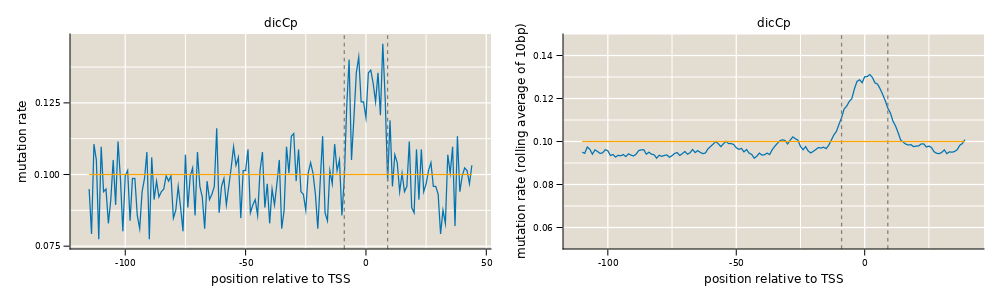

In [149]:
prom = "dicCp"
seq = df_seqs[df_seqs.promoter .== prom, :sequence][1][27:186]

pfm = df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter] |> PFM
mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter]) |> vec

mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter]) |> vec
mut_rate_av = [mean(mut_rate[i-5:i+5]) for i in 6:length(mut_rate)-5]
fig = Figure(resolution=(1000, 300))
ax = Axis(fig[1, 1])
lines!(ax, collect(-115:1:44), mut_rate)
vlines!(ax, 107-116, color="grey", linestyle=:dash)
vlines!(ax, 125-116, color="grey", linestyle=:dash)

lines!(ax, [-115, 44], [0.1, 0.1], color="orange")

println("Possible dicA binding site: ", seq[107:125])

ax.title = prom
ax.xlabel = "position relative to TSS"
ax.ylabel = "mutation rate"

ax2 = Axis(fig[1, 2])
lines!(ax2, collect(-110:1:39), mut_rate_av)
ylims!(ax2, 0.05, 0.15)
vlines!(ax2, 107-116, color="grey", linestyle=:dash)
vlines!(ax2, 125-116, color="grey", linestyle=:dash)

lines!(ax2, [-110, 39], [0.1, 0.1], color="orange")

println("Possible dicA binding site: ", seq[107:125])

ax2.title = prom
ax2.xlabel = "position relative to TSS"
ax2.ylabel = "mutation rate (rolling average of 10bp)"

save("../../../figures/dicCp_mutation_rate_oligos.pdf")

display(fig)

In [129]:
prom = "dicAp"
seq = df_seqs[df_seqs.promoter .== prom, :sequence][1][27:186]

pfm = df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter] |> PFM
mut_rate = 1 .- maximum(pfm, dims=1) ./ length(df_barcodes_thresh_100[df_barcodes_thresh_100.name .== prom, :promoter]) |> vec
fig = Figure(resolution=(500, 300))
ax = Axis(fig[1, 1])
lines!(ax, collect(-115:1:44), mut_rate)


vlines!(ax, 107-116, color="grey", linestyle=:dash)
vlines!(ax, 125-116, color="grey", linestyle=:dash)

lines!(ax, [-115, 44], [0.1, 0.1], color="orange")

println("Possible dicA binding site: ", seq[107:125])

ax.title = prom
ax.xlabel = "position relative to TSS"
ax.ylabel = "mutation rate"
save("../../../figures/dicAp_mutation_rate_oligos.pdf")

display(fig)

LoadError: BoundsError: attempt to access 0-element Vector{LongSequence{DNAAlphabet{4}}} at index [1]

## Summary

In [ ]:
"""
    c_boxplot(ax, x, y; jitter=true, width=0.5, jitterwidth=1, markersize=10)

Custom function to make a boxplot.

# Parameters
------------
- ax: Makie Axis
- x: Single x value for box-whisker plot
- y: Datapoints
- jitter: Boolean, if datapoints should be jittered or not, default true
- width: width of box, default 0.5
- jitterwidth: range of jitter, only effective if jitter is true. Default is 1
- markersize: Point size of markers, default is 10
"""
function c_boxplot(ax, x, y; jitter=true, width=0.5, jitterwidth=1, markersize=10, label=:none)

    # Sort dataset
    y_sort = sort(y)
    # Find median
    med = median(y)
    # Find quantiles
    low_q = quantile(y_sort, 0.25, sorted=true)
    high_q = quantile(y_sort, 0.75, sorted=true)
    # Find interquantile range
    iqr = high_q - low_q
    # Find ends of whiskes
    whisk_max = y_sort[findlast(t -> t < high_q + 1.5 * iqr, y_sort)]
    whisk_min = y_sort[findfirst(t -> t > low_q - 1.5 * iqr, y_sort)]
    label
    # Make scatter plot
    if jitter
        scatter!(
            ax, 
            fill(x, length(y)) .+ (rand(length(y)) .- 0.5) .* jitterwidth, 
            y,
            markersize=markersize,
            label=label
            )
    else
        scatter!(
            ax, 
            fill(x, length(y)), 
            y,
            markersize=markersize,
            label=label
            )
    end
    lines!(ax, 
        [x - width, x + width], 
        [med, med],
        linewidth=2,
        color="black"
    )

    # Box
    lines!(ax, 
        [x - width, x + width], 
        [low_q, low_q],
        linewidth=2,
        color="black"
    )
    lines!(ax, 
        [x - width, x + width], 
        [high_q, high_q],
        linewidth=2,
        color="black"
    )
    lines!(ax, 
        [x - width, x - width], 
        [low_q, high_q],
        linewidth=2,
        color="black"
    )
    lines!(ax, 
        [x + width, x + width], 
        [low_q, high_q],
        linewidth=2,
        color="black"
    )

    # Whiskers
    lines!(ax, 
        [x, x], 
        [high_q, whisk_max],
        linewidth=2,
        color="black"
    )
    lines!(ax, 
        [x, x], 
        [low_q, whisk_min],
        linewidth=2,
        color="black"
    )
    lines!(ax, 
        [x - width, x + width], 
        [whisk_max, whisk_max],
        linewidth=2,
        color="black"
    )
    lines!(ax, 
        [x - width, x + width], 
        [whisk_min, whisk_min],
        linewidth=2,
        color="black"
    )
    return ax
end



c_boxplot

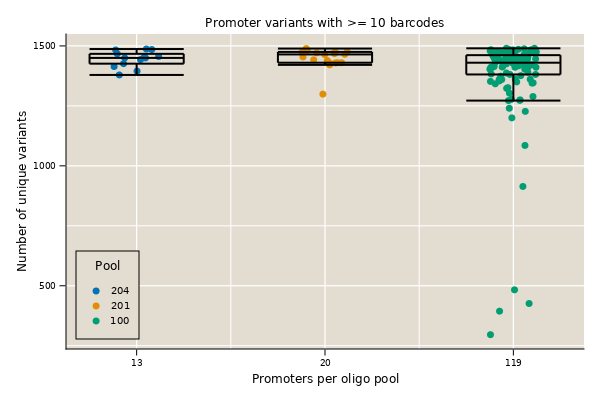

In [ ]:
fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1])

ax = c_boxplot(
    ax, 
    1 ,
    df_unique_per_prom_204.promoter_num_unique; 
    jitter=true, 
    width=0.25, 
    markersize=7, 
    jitterwidth=0.25,
    label="204"
    )
#ax = c_boxplot(ax, 2 ,df_unique_per_prom_110.promoter_num_unique; jitter=true)
ax = c_boxplot(
    ax, 
    2,
    df_unique_per_prom_201.promoter_num_unique; 
    jitter=true, 
    width=0.25, 
    markersize=7, 
    jitterwidth=0.25,
    label="201"
    )
ax = c_boxplot(
    ax,
    3,
    df_unique_per_prom_100.promoter_num_unique; 
    jitter=true, 
    width=0.25, 
    markersize=7, 
    jitterwidth=0.25,
    label="100"
    )

ax.title = "Promoter variants with >= 10 barcodes"
ax.xticks = ([1, 2, 3], ["13", "20", "119"])
ax.xlabel = "Promoters per oligo pool"
ax.ylabel = "Number of unique variants"

axislegend("Pool", position=:lb, titlesize=12, labelsize=10)
save("../../../figures/unique_var_per_pool.pdf", fig)

fig

In [131]:
df_filt_100.name |> unique |> sort |> println

["None", "TSS_1414_storz_regulondb", "TSS_18061_regulondb", "TSS_4654_wanner_regulondb", "TSS_4655_regulondb", "TSS_6311_regulondb", "aceBp", "acrAp", "acrBp", "acrZp", "araBp", "araCp", "blrp", "cpxRp", "cpxRp2", "crpp1", "crpp2", "crpp3", "cusCp", "dgoRp", "dicCp", "dinQp", "ecnBp", "elaBp", "fldAp", "ftsKp1", "ftsKp2", "furpa", "furpb", "galEp", "galEp1", "galEp2", "galEp3", "galSp", "gatYp", "gatZp", "ghoSp", "gyrAp", "hdeAp", "hdeAp2", "hyuA_predicted", "icdC_predicted", "ihfAp4", "intE_xisE_ymfH_predicted", "kbpp4", "lacIp", "ldrDp", "lpp", "lppp2", "marRp", "mcbAp5", "mglBp", "mglBp2", "mhpRp1", "mhpRp2", "mprAp", "mtnp", "mtnp2", "ompFp", "ompFp2", "ompRp1", "ompRp2", "ompRp3", "ompRp4", "pheMp", "ratA_yfjF_predicted", "rcsBp1", "rcsBp2", "rcsDp", "rdlDp", "recNp", "relBp", "rspAp", "sohAp", "ssnAp", "sulAp", "tabA_predicted", "tfaE_stfE_predicted", "tisBp", "tmaR_predicted", "tnaCp", "tolCp1", "tolCp2", "tolCp3", "tolCp4", "uacT_predicted", "uofp", "xdhAp1", "xdhAp2", "xylAp",